In [1]:
from nn_globals import *

from nn_encode import nlayers, nvariables

from nn_data import (muon_data_split, pileup_data_split, mix_training_inputs)

from nn_models import (create_model_bn2, lr_decay, modelbestcheck, modelbestcheck_weights)

from nn_training import train_model

from nn_pruning import prune_model

%matplotlib inline

[INFO    ] Using cmssw CMSSW_10_4_0
[INFO    ] Using numpy 1.15.1
[INFO    ] Using tensorflow 1.6.0
Using TensorFlow backend.
[INFO    ] Using keras 2.1.4
[INFO    ] .. list devices: [_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456)]
[INFO    ] Using scipy 1.1.0
[INFO    ] Using sklearn 0.19.1
[INFO    ] Using matplotlib 2.2.3


In [2]:
# Training parameters

do_training = False

run2_input = False

omtf_input = False

model_name = 'model'

epochs = 300

batch_size = 2048

tile = 4

# ______________________________________________________________________________
if run2_input:
  from nn_encode_run3 import nlayers, nvariables
  from nn_data_run3 import (muon_data_split, pileup_data_split, mix_training_inputs)
  
  infile_muon = infile_muon_run3
  infile_pileup = infile_pileup_run3
  
  model_name = 'model_run3'
  
  epochs = 300
  
  tile = 6

# ______________________________________________________________________________
if omtf_input:
  from nn_encode_omtf import nlayers, nvariables
  from nn_data_omtf import (muon_data_split, pileup_data_split, mix_training_inputs)
  
  infile_muon = infile_muon_omtf
  infile_pileup = infile_pileup_omtf
  
  model_name = 'model_omtf'
  
  epochs = 450
  
  tile = 10

### Import data

In [3]:
# Import muon data
# 'x' is the array of input variables, 'y' is the q/pT

test_size = 0.29
if run2_input:
  test_size = 0.304
if omtf_input:
  test_size = 0.311

x_train, x_test, y_train, y_test, dxy_train, dxy_test, dz_train, dz_test, w_train, w_test, x_mask_train, x_mask_test, x_road_train, x_road_test = \
    muon_data_split(infile_muon, reg_pt_scale=reg_pt_scale, reg_dxy_scale=reg_dxy_scale, test_size=test_size)

# Add discrimator output node
if add_noise:
  labels = np.where(np.abs(1.0/y_train) >= discr_pt_cut/reg_pt_scale, 1., mask_value)
  y_train = [y_train, labels.astype(np.float32)]
  labels = np.where(np.abs(1.0/y_test) >= discr_pt_cut/reg_pt_scale, 1., mask_value)
  y_test = [y_test, labels.astype(np.float32)]

[INFO    ] Loading muon data from ../test7/histos_tba.27.npz ...
[INFO    ] Loaded the variables with shape (3310372, 164)
[INFO    ] Loaded the parameters with shape (3310372, 6)
[INFO    ] Loaded the encoded variables with shape (3310372, 36)
[INFO    ] Loaded the encoded parameters with shape (3310372,)
[INFO    ] Loaded # of training and testing events: (2350364, 960008)


In [4]:
# Import pileup data
# 'x' is the array of input variables, 'aux' is pileup info (jobid, ievt, highest_part_pt, highest_track_pt)

test_job = 159

pu_x_train, pu_x_test, pu_aux_train, pu_aux_test, pu_w_train, pu_w_test, pu_x_mask_train, pu_x_mask_test, pu_x_road_train, pu_x_road_test = \
    pileup_data_split(infile_pileup, reg_pt_scale=reg_pt_scale, reg_dxy_scale=reg_dxy_scale, test_job=test_job)

# Add output nodes for pileup data
if add_noise:
  labels = np.zeros((pu_x_train.shape[0],), dtype=np.float32)
  pu_y_train = [np.full((pu_x_train.shape[0],), mask_value, dtype=np.float32), labels]
  labels = np.zeros((pu_x_test.shape[0],), dtype=np.float32)
  pu_y_test = [np.full((pu_x_test.shape[0],), mask_value, dtype=np.float32), labels]

[INFO    ] Loading pileup data from ../test7/histos_tbd.27.npz ...
[INFO    ] Loaded the variables with shape (1496354, 164)
[INFO    ] Loaded the auxiliary PU info with shape (1496354, 4)
[INFO    ] Loaded the encoded variables with shape (1496354, 36)
[INFO    ] Loaded the encoded auxiliary PU info with shape (1496354, 4)
[INFO    ] Loaded # of training and testing events: (1231685, 264669)


### Training

In [5]:
# Training with Batch Normalization
# 'model' is a densely connected NN with 3 hidden layers and 2 output nodes, q/pT and PU discriminator
# BN is applied right after the input layers

if do_training:
  assert(keras.backend.backend() == 'tensorflow')
  
  if add_noise:
    x_train_new, y_train_new = mix_training_inputs(x_train, y_train, pu_x_train, pu_y_train, pu_aux_train, 
                                                   discr_pt_cut=discr_pt_cut, tile=tile)
    #x_train_new, y_train_new = mix_training_inputs_2(x_train, y_train, highpt_x_train, highpt_y_train, pu_x_train, pu_y_train, pu_aux_train, 
    #                                                 discr_pt_cut=discr_pt_cut, tile=tile)
  else:
    raise Exception('add_noise must be set to True')
  
  model = create_model_bn2(nvariables=nvariables, lr=learning_rate, clipnorm=gradient_clip_norm, 
                           l1_reg=l1_reg, l2_reg=l2_reg, discr_loss_weight=discr_loss_weight,
                           nodes1=30, nodes2=25, nodes3=20)
  logger.info('Training model with l1_reg: {0} l2_reg: {0}'.format(l1_reg, l2_reg))
  
  # Start training
  history = train_model(model, x_train_new, y_train_new,
                        model_name=model_name, epochs=epochs, batch_size=batch_size,
                        callbacks=[lr_decay,], validation_split=0.1, verbose=1)
  
  metrics = [len(history.history['loss']), history.history['loss'][-1], history.history['regr_loss'][-1], history.history['discr_loss'][-1], 
             history.history['val_loss'][-1], history.history['val_regr_loss'][-1], history.history['val_discr_loss'][-1]]
  logger.info('Epoch {0}/{0} - loss: {1} - regr_loss: {2} - discr_loss: {3} - val_loss: {4} - val_regr_loss: {5} - val_discr_loss: {6}'.format(*metrics))

In [6]:
# Validation

if do_training:
  # Loss
  plt.figure()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.ylim(2,7)
  plt.show()

if False:
  plt.figure()
  plt.plot(history.history['regr_loss'])
  plt.plot(history.history['val_regr_loss'])
  plt.title('regr loss')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

  plt.figure()
  plt.plot(history.history['discr_loss'])
  plt.plot(history.history['val_discr_loss'])
  plt.title('discr loss')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

### Regression Results

In [7]:
# Setup matplotlib
plt.style.use('tdrstyle.mplstyle')

from nn_plotting import (gaus, fit_gaus, separation_score, find_efficiency_errors, \
                         np_printoptions)

from sklearn.metrics import (mean_squared_error, mean_absolute_error, median_absolute_error, \
                             roc_curve, roc_auc_score, log_loss)

eps = 1e-7
my_cmap = plt.cm.viridis
my_cmap.set_under('w',1)
my_palette = ("#377eb8", "#e41a1c", "#984ea3", "#ff7f00", "#4daf4a")

In [8]:
# Load model and predict outputs
from nn_models import load_my_model, update_keras_custom_objects
update_keras_custom_objects()
#K.set_learning_phase(0)
loaded_model = load_my_model(name=model_name+'.json', weights_name=model_name+'_weights.h5')
loaded_model.trainable = False
assert not loaded_model.updates

nentries_test = x_test.shape[0]//8

# Prepare y_test_true, y_test_pred
y_test_true = y_test
if isinstance(y_test_true, list):
  y_test_true = y_test_true[0]
y_test_true = y_test_true[:nentries_test].copy()
y_test_true /= reg_pt_scale
if y_test_true.ndim == 1:
  y_test_true = y_test_true[:, np.newaxis]

y_test_pred = loaded_model.predict(x_test[:nentries_test], batch_size=4096)
if isinstance(y_test_pred, list):
  y_test_pred, y_test_pred_discr = y_test_pred
y_test_pred /= reg_pt_scale
#print y_test_true.shape, y_test_true
#print y_test_pred.shape, y_test_pred

In [9]:
# Prepare pu_y_test_true, pu_y_test_pred
pu_y_test_true = np.full((pu_x_test.shape[0], 1), mask_value, dtype=np.float32)
pu_y_test_pred = loaded_model.predict(pu_x_test, batch_size=4096)
if isinstance(pu_y_test_pred, list):
  pu_y_test_pred, pu_y_test_pred_discr = pu_y_test_pred
pu_y_test_pred /= reg_pt_scale
#print pu_y_test_true.shape, pu_y_test_true
#print pu_y_test_pred.shape, pu_y_test_pred

[INFO    ] # of entries: 120001, mean: 4.353721e-04, std: 3.551461e-02, mse: 1.416218e-03, mae: 2.406834e-02, mad: 2.295454e-02
[INFO    ] gaus fit (a, mu, sig): 1.037584e+04, 2.547631e-04, 2.009557e-02
[INFO    ] # of entries: 19367, mean: 8.386989e-05, std: 1.278974e-02, mse: 5.524324e-04, mae: 9.628573e-03, mad: 8.172309e-03
[INFO    ] gaus fit (a, mu, sig): 1.569188e+03, 3.585083e-05, 7.406007e-03
/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-matplotlib/2.2.3-ikaegh/lib/python2.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


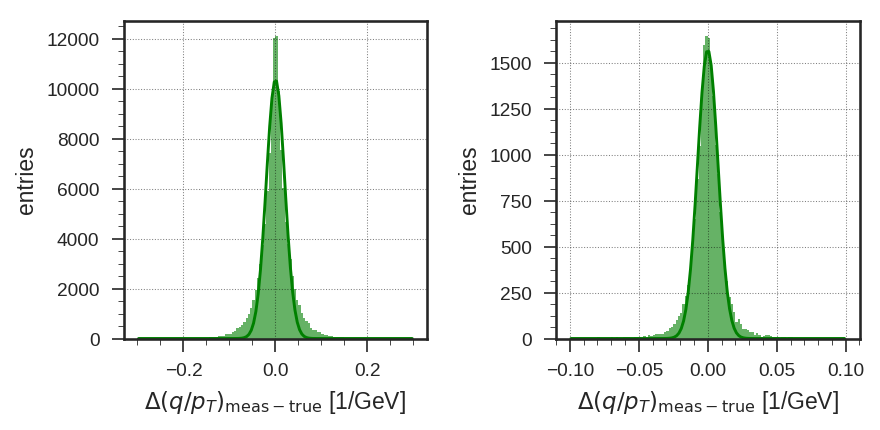

In [10]:
# Plot Delta(q/pT)
fig, axs = plt.subplots(1, 2, figsize=(6,6/2), tight_layout=True)

ya = y_test_true
yb = y_test_pred
yy = yb - ya

mse, mae, mad = mean_squared_error(ya, yb), mean_absolute_error(ya, yb), median_absolute_error(ya, yb)/0.6745  # (y_true, y_pred)
hist, edges, _ = axs[0].hist(yy, bins=120, range=(-0.3,0.3), histtype='stepfilled', facecolor='g', alpha=0.6)
logger.info('# of entries: {0}, mean: {1:e}, std: {2:e}, mse: {3:e}, mae: {4:e}, mad: {5:e}'.format(len(yy), np.mean(yy), np.std(yy[np.abs(yy)<0.3]), mse, mae, mad))
popt = fit_gaus(hist, edges, mu=0., sig=np.std(yy[np.abs(yy)<0.3]))
logger.info('gaus fit (a, mu, sig): {0:e}, {1:e}, {2:e}'.format(popt[0], popt[1], popt[2]))
xdata = (edges[1:] + edges[:-1])/2
axs[0].plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]), color='g')
axs[0].set_xlabel(r'$\Delta(q/p_{T})_{\mathrm{meas-true}}$ [1/GeV]')
axs[0].set_ylabel(r'entries')

sel = (np.abs(1.0/y_test_true) > discr_pt_cut_high)
ya = ya[sel]
yb = yb[sel]
yy = yy[sel]

mse, mae, mad = mean_squared_error(ya, yb), mean_absolute_error(ya, yb), median_absolute_error(ya, yb)/0.6745  # (y_true, y_pred)
hist, edges, _ = axs[1].hist(yy, bins=120, range=(-0.3/3,0.3/3), histtype='stepfilled', facecolor='g', alpha=0.6)
logger.info('# of entries: {0}, mean: {1:e}, std: {2:e}, mse: {3:e}, mae: {4:e}, mad: {5:e}'.format(len(yy), np.mean(yy), np.std(yy[np.abs(yy)<0.3/3]), mse, mae, mad))
popt = fit_gaus(hist, edges, mu=0., sig=np.std(yy[np.abs(yy)<0.3/3]))
logger.info('gaus fit (a, mu, sig): {0:e}, {1:e}, {2:e}'.format(popt[0], popt[1], popt[2]))
xdata = (edges[1:] + edges[:-1])/2
axs[1].plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]), color='g')
axs[1].set_xlabel(r'$\Delta(q/p_{T})_{\mathrm{meas-true}}$ [1/GeV]')
axs[1].set_ylabel(r'entries')

plt.show()

[INFO    ] # of entries: 120001, mean: 1.241357e-01, std: 1.196328e-01, mse: 5.762605e+01, mae: 2.477152e-01, mad: 1.330369e-01
[INFO    ] gaus fit (a, mu, sig): 8.981367e+03, -7.981745e-03, 1.206087e-01
[INFO    ] # of entries: 19367, mean: 5.084540e-01, std: 1.455503e-01, mse: 2.783783e+02, mae: 7.845941e-01, mad: 2.604430e-01
[INFO    ] gaus fit (a, mu, sig): 8.235157e+02, -7.173771e-02, 1.992504e-01


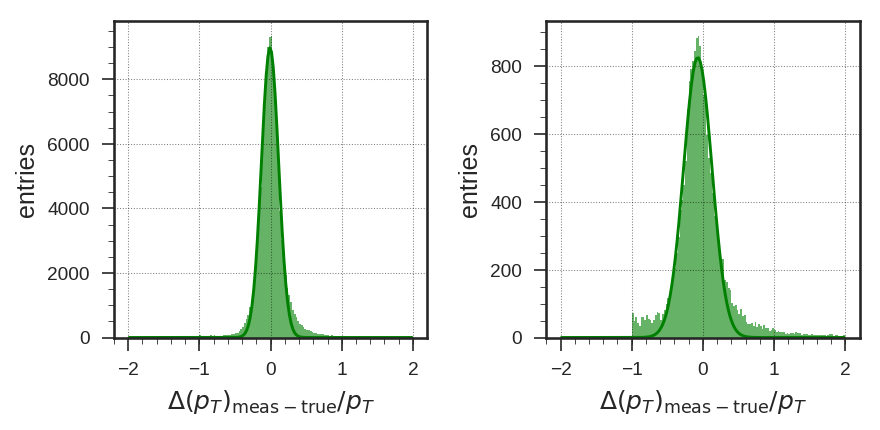

In [11]:
# Plot Delta(q/pT) / pT
fig, axs = plt.subplots(1, 2, figsize=(6,6/2), tight_layout=True)

ya = np.abs(y_test_true/y_test_true)
yb = np.abs(y_test_true/y_test_pred)
yy = yb - ya

mse, mae, mad = mean_squared_error(ya, yb), mean_absolute_error(ya, yb), median_absolute_error(ya, yb)/0.6745  # (y_true, y_pred)
hist, edges, _ = axs[0].hist(yy, bins=160, range=(-2,2), histtype='stepfilled', facecolor='g', alpha=0.6)
logger.info('# of entries: {0}, mean: {1:e}, std: {2:e}, mse: {3:e}, mae: {4:e}, mad: {5:e}'.format(len(yy), np.mean(yy), np.std(yy[np.abs(yy)<0.3]), mse, mae, mad))
popt = fit_gaus(hist, edges, mu=0., sig=np.std(yy[np.abs(yy)<1.5]))
logger.info('gaus fit (a, mu, sig): {0:e}, {1:e}, {2:e}'.format(popt[0], popt[1], popt[2]))
xdata = (edges[1:] + edges[:-1])/2
axs[0].plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]), color='g')
axs[0].set_xlabel(r'$\Delta(p_{T})_{\mathrm{meas-true}} / p_{T}$', fontsize=12)
axs[0].set_ylabel(r'entries', fontsize=12)

sel = (np.abs(1.0/y_test_true) > discr_pt_cut_high)
ya = ya[sel]
yb = yb[sel]
yy = yy[sel]

mse, mae, mad = mean_squared_error(ya, yb), mean_absolute_error(ya, yb), median_absolute_error(ya, yb)/0.6745  # (y_true, y_pred)
hist, edges, _ = axs[1].hist(yy, bins=160, range=(-2,2), histtype='stepfilled', facecolor='g', alpha=0.6)
logger.info('# of entries: {0}, mean: {1:e}, std: {2:e}, mse: {3:e}, mae: {4:e}, mad: {5:e}'.format(len(yy), np.mean(yy), np.std(yy[np.abs(yy)<0.3]), mse, mae, mad))
popt = fit_gaus(hist, edges, mu=0., sig=np.std(yy[np.abs(yy)<1.5]))
logger.info('gaus fit (a, mu, sig): {0:e}, {1:e}, {2:e}'.format(popt[0], popt[1], popt[2]))
xdata = (edges[1:] + edges[:-1])/2
axs[1].plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]), color='g')
axs[1].set_xlabel(r'$\Delta(p_{T})_{\mathrm{meas-true}} / p_{T}$', fontsize=12)
axs[1].set_ylabel(r'entries', fontsize=12)

plt.show()

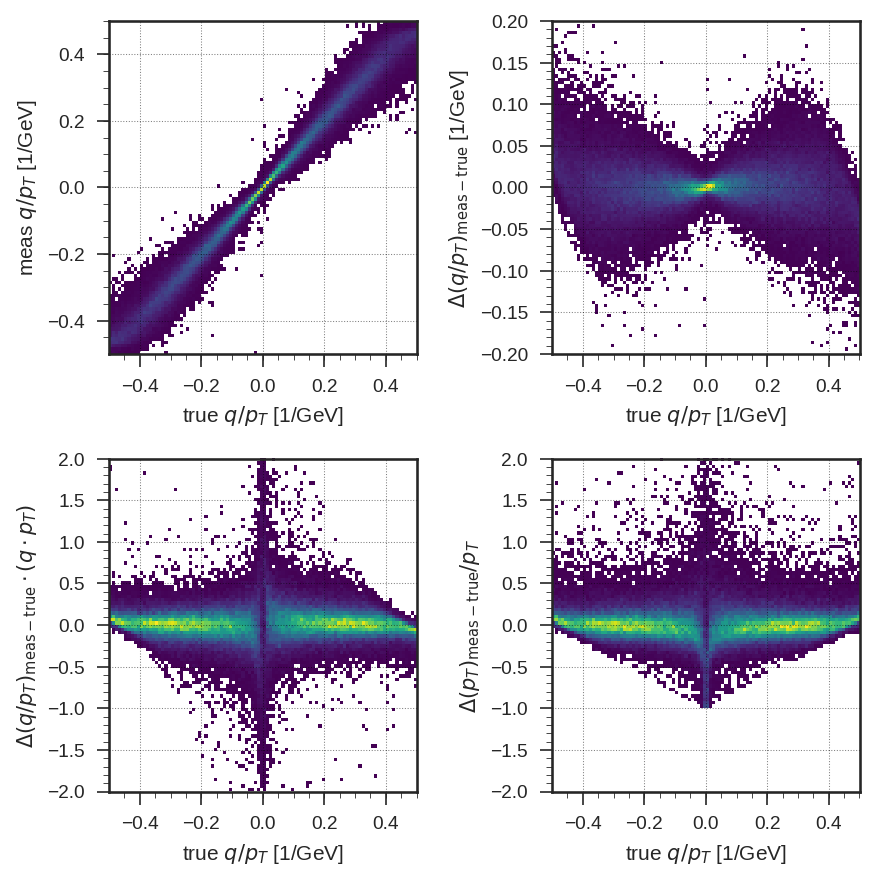

In [12]:
# Plot resolution plots
fig, axs = plt.subplots(2, 2, figsize=(6,6), tight_layout=True)

xx = y_test_true
yy = y_test_pred
axs[0,0].hist2d(np.squeeze(xx), np.squeeze(yy), bins=(100,100), range=((-0.5,0.5),(-0.5,0.5)), vmin=1, cmap=my_cmap)
axs[0,0].set_xlabel(r'true $q/p_{T}$ [1/GeV]', fontsize=10)
axs[0,0].set_ylabel(r'meas $q/p_{T}$ [1/GeV]', fontsize=10)

yy = y_test_pred - y_test_true
axs[0,1].hist2d(np.squeeze(xx), np.squeeze(yy), bins=(100,100), range=((-0.5,0.5),(-0.2,0.2)), vmin=1, cmap=my_cmap)
axs[0,1].set_xlabel(r'true $q/p_{T}$ [1/GeV]', fontsize=10)
axs[0,1].set_ylabel(r'$\Delta(q/p_{T})_{\mathrm{meas-true}}$ [1/GeV]', fontsize=10)

yy = (y_test_pred - y_test_true)/np.abs(y_test_true)
axs[1,0].hist2d(np.squeeze(xx), np.squeeze(yy), bins=(100,100), range=((-0.5,0.5),(-2,2)), vmin=1, cmap=my_cmap)
axs[1,0].set_xlabel(r'true $q/p_{T}$ [1/GeV]', fontsize=10)
axs[1,0].set_ylabel(r'$\Delta(q/p_{T})_{\mathrm{meas-true}} \cdot (q \cdot p_{T})$', fontsize=10)

yy = (np.abs(y_test_true/y_test_pred) - np.abs(y_test_true/y_test_true))
axs[1,1].hist2d(np.squeeze(xx), np.squeeze(yy), bins=(100,100), range=((-0.5,0.5),(-2,2)), vmin=1, cmap=my_cmap)
axs[1,1].set_xlabel(r'true $q/p_{T}$ [1/GeV]', fontsize=10)
axs[1,1].set_ylabel(r'$\Delta(p_{T})_{\mathrm{meas-true}} / p_{T}$', fontsize=10)

plt.show()

In [13]:
# Make better resolution plot
# resolution defined as delta pT over pT (no charge), binned in 1/pT (also no charge)
xx = np.abs(y_test_true)
yy = (np.abs(y_test_true/y_test_pred) - np.abs(y_test_true/y_test_true))
xx = np.squeeze(xx)
yy = np.squeeze(yy)

nbinsx = 100
xedges = np.linspace(0, 0.5, num=nbinsx+1)
inds = np.digitize(xx, xedges[1:])

xxx = np.zeros(nbinsx, dtype=np.float32)
yyy = np.zeros(nbinsx, dtype=np.float32)
zzz = np.zeros(nbinsx, dtype=np.float32)
ttt = np.zeros(nbinsx, dtype=np.float32)
for i in xrange(nbinsx):
  xx_i = xx[inds==i]
  if len(xx_i) < 100:  # not enough stats
    continue
  
  pt = np.mean(xx_i)
  pt = 1.0/pt
  
  yy_i = yy[inds==i]
  yy_i = yy_i[(-1 <= yy_i) & (yy_i <= 1.5)]
  mu, sig = np.mean(yy_i), np.std(yy_i)
  assert(np.abs(mu) < 1)
  assert(np.abs(sig) < 2)
  
  hist, edges = np.histogram(yy_i, bins=160, range=(-2,2))
  xdata = (edges[1:] + edges[:-1])/2
  popt = fit_gaus(hist, edges, mu=0.0, sig=0.2)
  #print i, len(xx_i), mu, sig, pt, popt
  
  # Estimate high tail
  ydata = gaus(xdata, popt[0], popt[1], popt[2])
  zdata = hist - ydata
  zdata[zdata < 0] = 0    # ignore hist < gaus
  zdata[xdata < 0.2] = 0  # ignore low tail
  hightail = zdata.sum()/len(xx_i)
  #print i, len(xx_i), zdata.sum(), hightail
  
  # Estimate coverage
  pct = np.percentile(yy_i, [10, 50, 90], overwrite_input=True)
  coverage = -1*pct[0]/popt[2]
  
  if 14. < pt < 15.:
    ind_14GeV, xx_14GeV, yy_14GeV = i, xx_i, yy_i
  elif 20. < pt < 22.:
    ind_20GeV, xx_20GeV, yy_20GeV = i, xx_i, yy_i
  elif 25. < pt < 28.:
    ind_25GeV, xx_25GeV, yy_25GeV = i, xx_i, yy_i
  
  xxx[i] = pt
  yyy[i] = popt[2]
  zzz[i] = hightail
  ttt[i] = coverage

[INFO    ] gaus fit (a, mu, sig): 7.837547e+01, -4.039662e-02, 1.525961e-01
[INFO    ] gaus fit (a, mu, sig): 7.325953e+01, -3.676230e-02, 1.710694e-01
[INFO    ] gaus fit (a, mu, sig): 6.969796e+01, -7.144509e-02, 1.707767e-01


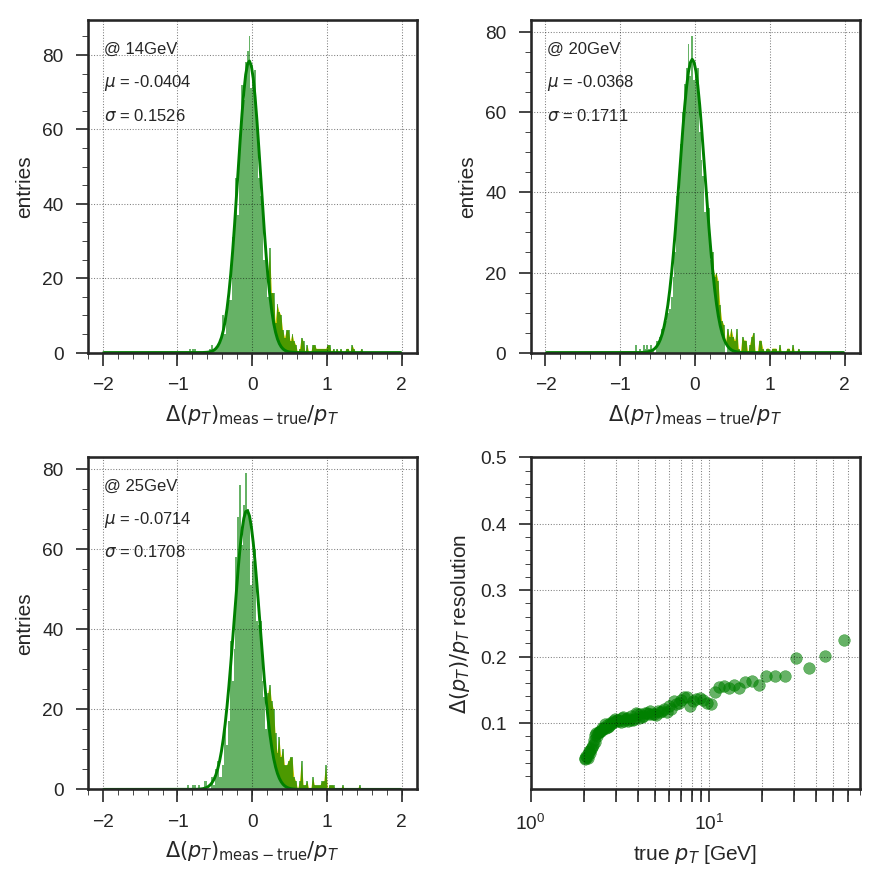

In [14]:
# Make better resolution plot
fig, axs = plt.subplots(2, 2, figsize=(6,6), tight_layout=True)

def doit():
  hist, edges, _ = ax.hist(yy, bins=160, range=(-2,2), histtype='stepfilled', facecolor='g', alpha=0.6)
  xdata = (edges[1:] + edges[:-1])/2
  popt = fit_gaus(hist, edges, mu=0.0, sig=0.2)
  logger.info('gaus fit (a, mu, sig): {0:e}, {1:e}, {2:e}'.format(popt[0], popt[1], popt[2]))
  
  # Estimate high tail
  ydata = gaus(xdata, popt[0], popt[1], popt[2])
  zdata = (hist - ydata)
  zdata[zdata < 0] = 0    # ignore hist < gaus
  zdata[xdata < 0.2] = 0  # ignore low tail
  
  ax.plot(xdata, ydata, color='g')
  ax.fill_between(xdata, ydata, ydata+zdata, facecolor='y')
  ax.text(0.05, 0.9, r'@ %iGeV' % pt, transform=ax.transAxes, fontsize=8)
  ax.text(0.05, 0.8, r'$\mu$ = {0:.4f}'.format(popt[1]), transform=ax.transAxes, fontsize=8)
  ax.text(0.05, 0.7, r'$\sigma$ = {0:.4f}'.format(popt[2]), transform=ax.transAxes, fontsize=8)
  ax.set_xlabel(r'$\Delta(p_{T})_{\mathrm{meas-true}} / p_{T}$', fontsize=10)
  ax.set_ylabel(r'entries', fontsize=10)

ax = axs[0,0]
yy = yy_14GeV
pt = 14
doit()

ax = axs[0,1]
yy = yy_20GeV
pt = 20
doit()

ax = axs[1,0]
yy = yy_25GeV
pt = 25
doit()

ax = axs[1,1]
ax.scatter(xxx, yyy, color='g', alpha=0.6)
ax.set_xlim(1,70)
ax.set_ylim(0,0.5)
ax.set_xlabel(r'true $p_{T}$ [GeV]', fontsize=10)
ax.set_ylabel(r'$\Delta(p_{T}) / p_{T}$ resolution', fontsize=10)
ax.set_xscale('log')
ax.set_xticks(list(xrange(1,10)) + list(xrange(10,70,10)))
ax.set_yticks([0.1,0.2,0.3,0.4,0.5])

plt.show()

[INFO    ] high tail prob: 9.212328e-02, 7.560916e-02, 1.170661e-01


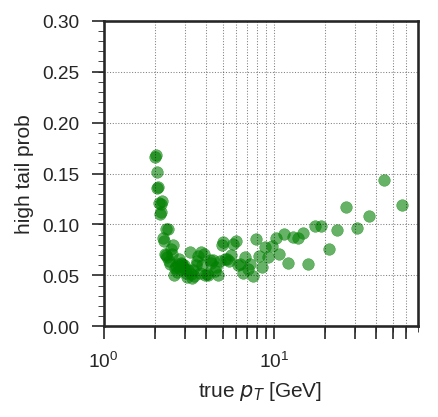

In [15]:
# Estimate high tail that is underestimated by gaus fit
logger.info('high tail prob: {0:e}, {1:e}, {2:e}'.format(zzz[ind_14GeV],zzz[ind_20GeV],zzz[ind_25GeV]))

fig, ax = plt.subplots(1, 1, figsize=(5.4/2,5.4/2))
ax.scatter(xxx, zzz, color='g', alpha=0.6)
ax.set_xlim(1,70)
ax.set_ylim(0,0.3)
ax.set_xlabel(r'true $p_{T}$ [GeV]', fontsize=10)
ax.set_ylabel(r'high tail prob', fontsize=10)
ax.set_xscale('log')
ax.set_xticks(list(xrange(1,10)) + list(xrange(10,70,10)))
#ax.set_yticks([0.1,0.2,0.3,0.4,0.5])

plt.show()

[INFO    ] coverage # of sigmas: 1.495059e+00, 1.387635e+00, 1.552042e+00


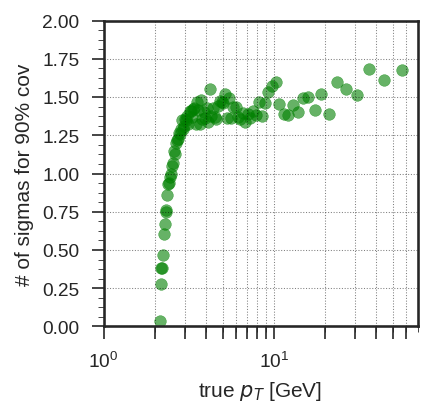

In [16]:
# Estimate coverage, find required number of sigmas for 90% coverage
# If truly gaussian, the required number of sigmas is 1.28155
import scipy.special
#print scipy.special.erfinv(0.80) * np.sqrt(2)
logger.info('coverage # of sigmas: {0:e}, {1:e}, {2:e}'.format(ttt[ind_14GeV],ttt[ind_20GeV],ttt[ind_25GeV]))

fig, ax = plt.subplots(1, 1, figsize=(5.4/2,5.4/2))
ax.scatter(xxx, ttt, color='g', alpha=0.6)
ax.set_xlim(1,70)
ax.set_ylim(0,2)
ax.set_xlabel(r'true $p_{T}$ [GeV]', fontsize=10)
ax.set_ylabel(r'# of sigmas for 90% cov', fontsize=10)
ax.set_xscale('log')
ax.set_xticks(list(xrange(1,10)) + list(xrange(10,70,10)))
#ax.set_yticks([0.1,0.2,0.3,0.4,0.5])

plt.show()

### Classification Results

[INFO    ] # of entries: (120001, 1307), ll: 8.227623e-02, ss: 9.781463e-01


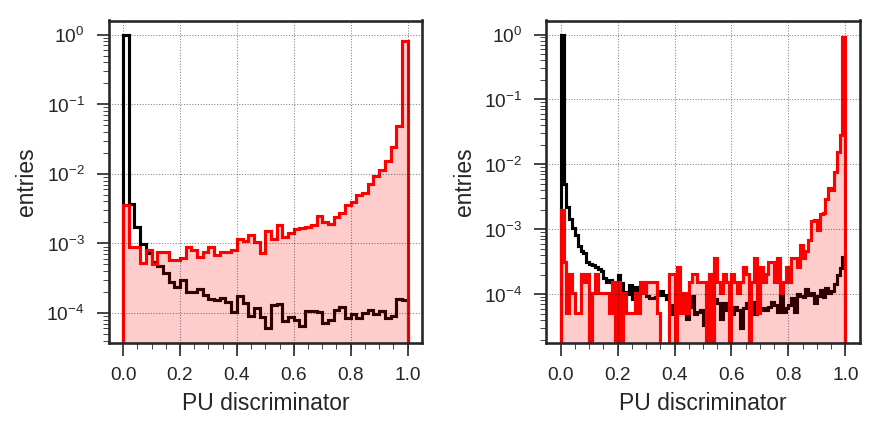

In [17]:
# Plot discriminator
fig, axs = plt.subplots(1, 2, figsize=(6,6/2), tight_layout=True)

# pT > 8 GeV, corresponding to 10 GeV trigger threshold
y_test_sel = np.abs(1.0/y_test_true) > discr_pt_cut
pu_y_test_sel = ~(pu_aux_test[:,2] > discr_pt_cut)  # veto PU events with high-pT tracks
if pu_y_test_sel.ndim == 1:
  pu_y_test_sel = pu_y_test_sel[:, np.newaxis]

yy0 = pu_y_test_pred_discr[pu_y_test_sel]
yy1 = y_test_pred_discr[y_test_sel]
ww0 = np.ones_like(yy0)/float(len(yy0))
ww1 = np.ones_like(yy1)/float(len(yy1))
axs[0].hist(yy0, bins=50, range=(0,1), weights=ww0, histtype='step', color='black', lw=1.5)
axs[0].hist(yy1, bins=50, range=(0,1), weights=ww1, histtype='stepfilled', color='red', alpha=0.2)
axs[0].hist(yy1, bins=50, range=(0,1), weights=ww1, histtype='step', color='red', lw=1.5)
axs[0].set_xlabel(r'PU discriminator')
axs[0].set_ylabel(r'entries')
axs[0].set_yscale('log')
axs[0].locator_params(axis='x', nbins=6)
ll = log_loss(np.zeros_like(yy0), yy0, labels=(0,1)) + log_loss(np.ones_like(yy1), yy1, labels=(0,1))  # (y_true, y_pred)
ss = separation_score(yy0, yy1)
logger.info('# of entries: {0}, ll: {1:e}, ss: {2:e}'.format((len(xx), len(yy)), ll, ss))

# pT > 14 GeV, corresponding to 20 GeV trigger threshold
y_test_sel_high = np.abs(1.0/y_test_true) > discr_pt_cut_high
pu_y_test_sel_high = ~(pu_aux_test[:,2] > discr_pt_cut_high)  # veto PU events with high-pT tracks
if pu_y_test_sel_high.ndim == 1:
  pu_y_test_sel_high = pu_y_test_sel_high[:, np.newaxis]

yy0 = pu_y_test_pred_discr[pu_y_test_sel_high]
yy1 = y_test_pred_discr[y_test_sel_high]
ww0 = np.ones_like(yy0)/float(len(yy0))
ww1 = np.ones_like(yy1)/float(len(yy1))
axs[1].hist(yy0, bins=100, range=(0,1), weights=ww0, histtype='step', color='black', lw=1.5)
axs[1].hist(yy1, bins=100, range=(0,1), weights=ww1, histtype='stepfilled', color='red', alpha=0.2)
axs[1].hist(yy1, bins=100, range=(0,1), weights=ww1, histtype='step', color='red', lw=1.5)
axs[1].set_xlabel(r'PU discriminator')
axs[1].set_ylabel(r'entries')
axs[1].set_yscale('log')
axs[1].locator_params(axis='x', nbins=6)

plt.show()

[INFO    ] auc: 0.980650669609
[INFO    ] thr: [0.9606, 0.9410, 0.9042, 0.8486, 0.8259, 0.7973, 0.7430, 0.6426, 0.2003]
[INFO    ] tpr: [0.9003, 0.9250, 0.9500, 0.9703, 0.9751, 0.9801, 0.9852, 0.9900, 0.9990]
[INFO    ] fpr: [0.0602, 0.0769, 0.1089, 0.1561, 0.1752, 0.1919, 0.2285, 0.2734, 0.4699]
[INFO    ] auc: 0.992356533406
[INFO    ] thr: [0.9945, 0.9911, 0.9816, 0.9671, 0.9620, 0.9525, 0.9311, 0.9035, 0.3803]
[INFO    ] tpr: [0.9007, 0.9262, 0.9543, 0.9726, 0.9757, 0.9803, 0.9866, 0.9903, 0.9991]
[INFO    ] fpr: [0.0196, 0.0283, 0.0327, 0.0414, 0.0458, 0.0523, 0.0588, 0.0741, 0.2179]


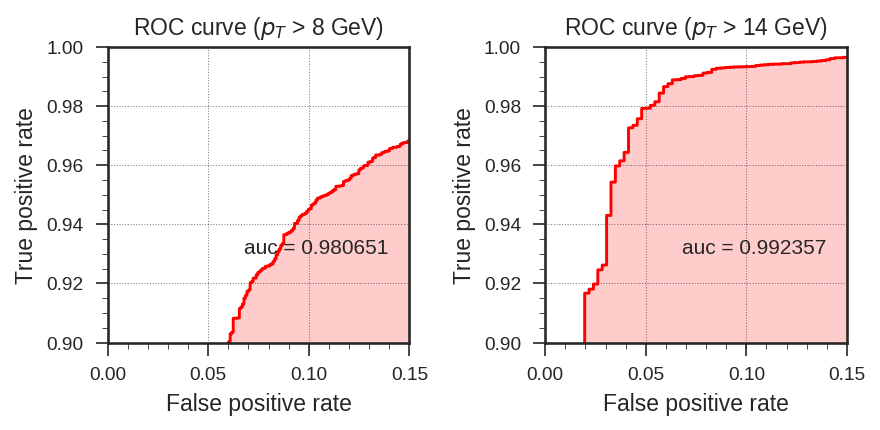

In [18]:
# Plot ROC
fig, axs = plt.subplots(1, 2, figsize=(6,6/2), tight_layout=True)

working_points = [0.9, 0.925, 0.95, 0.97, 0.975, 0.98, 0.985, 0.99, 0.999]

# pT > 8 GeV, corresponding to 10 GeV trigger threshold
xx = np.concatenate((np.ones_like(y_test_true)[y_test_sel], np.zeros_like(pu_y_test_true)[pu_y_test_sel]))
yy = np.concatenate((y_test_pred_discr[y_test_sel], pu_y_test_pred_discr[pu_y_test_sel]))
zz = np.concatenate((y_test_pred[y_test_sel], pu_y_test_pred[pu_y_test_sel]))

zzz = np.abs(1.0/zz) > discr_pt_cut
xxx = xx[zzz]
yyy = yy[zzz]
fpr, tpr, thresh = roc_curve(xxx, yyy)  # (y_true, y_pred)
auc = roc_auc_score(xxx, yyy)           # (y_true, y_pred)

idx = np.searchsorted(tpr, working_points)
logger.info("auc: {0}".format(auc))
logger.info("thr: {0}".format(np.array2string(thresh[idx], separator=', ', precision=4, floatmode='fixed')))
logger.info("tpr: {0}".format(np.array2string(tpr[idx], separator=', ', precision=4, floatmode='fixed')))
logger.info("fpr: {0}".format(np.array2string(fpr[idx], separator=', ', precision=4, floatmode='fixed')))

axs[0].plot(fpr, tpr, color='r')
axs[0].fill_between(fpr, tpr, color='r', alpha=0.2)
axs[0].set_title(r'ROC curve ($p_{T}$ > 8 GeV)')
axs[0].set_xlabel('False positive rate')
axs[0].set_ylabel('True positive rate')
axs[0].text(0.068, 0.93, 'auc = %f' % auc, fontsize=10)
axs[0].set_xlim(0.0,0.15)
axs[0].set_ylim(0.9,1.0)

# pT > 14 GeV, corresponding to 20 GeV trigger threshold
#xx = np.concatenate((np.ones_like(y_test_true)[y_test_sel_high], np.zeros_like(pu_y_test_true)[pu_y_test_sel_high]))
#yy = np.concatenate((y_test_pred_discr[y_test_sel_high], pu_y_test_pred_discr[pu_y_test_sel_high]))
#zz = np.concatenate((y_test_pred[y_test_sel_high], pu_y_test_pred[pu_y_test_sel_high]))

zzz = np.abs(1.0/zz) > discr_pt_cut_high
xxx = xx[zzz]
yyy = yy[zzz]
fpr, tpr, thresh = roc_curve(xxx, yyy)  # (y_true, y_pred)
auc = roc_auc_score(xxx, yyy)           # (y_true, y_pred)

idx = np.searchsorted(tpr, working_points)
logger.info("auc: {0}".format(auc))
logger.info("thr: {0}".format(np.array2string(thresh[idx], separator=', ', precision=4, floatmode='fixed')))
logger.info("tpr: {0}".format(np.array2string(tpr[idx], separator=', ', precision=4, floatmode='fixed')))
logger.info("fpr: {0}".format(np.array2string(fpr[idx], separator=', ', precision=4, floatmode='fixed')))

axs[1].plot(fpr, tpr, color='r')
axs[1].fill_between(fpr, tpr, color='r', alpha=0.2)
axs[1].set_title(r'ROC curve ($p_{T}$ > 14 GeV)')
axs[1].set_xlabel('False positive rate')
axs[1].set_ylabel('True positive rate')
axs[1].text(0.068, 0.93, 'auc = %f' % auc, fontsize=10)
axs[1].set_xlim(0.0,0.15)
axs[1].set_ylim(0.9,1.0)

plt.show()

### Efficiency & Rates 

In [19]:
# Build track producer

from six.moves import range, zip, map, filter

#pt_bins = (-0.5, -0.365, -0.26, -0.155, -0.07, 0.07, 0.155, 0.26, 0.365, 0.5)

pt_bins = (-0.49376795, -0.38895044, -0.288812, -0.19121648, -0.0810074, 0.0810074, 0.19121648, 0.288812, 0.38895044, 0.49376795)

#pt_bins = (-0.49349323, -0.38373062, -0.28128058, -0.18467896, -0.07760702, 0.07760702, 0.18467896, 0.28128058, 0.38373062, 0.49349323)

def find_pt_bin(pt):
  ipt = np.digitize((pt,), pt_bins[1:])[0]  # skip lowest edge
  ipt = np.clip(ipt, 0, len(pt_bins)-2)
  return ipt

def find_emtf_road_quality(ipt):
  best_ipt = find_pt_bin(0.)
  return best_ipt - np.abs(ipt - best_ipt)

theta_to_eta_lut = [
  2.599, 2.566, 2.534, 2.503, 2.473, 2.444, 2.415, 2.388, 2.361, 2.334,
  2.309, 2.284, 2.259, 2.236, 2.212, 2.190, 2.167, 2.145, 2.124, 2.103,
  2.083, 2.063, 2.043, 2.024, 2.005, 1.986, 1.968, 1.950, 1.932, 1.915,
  1.898, 1.881, 1.864, 1.848, 1.832, 1.816, 1.800, 1.785, 1.770, 1.755,
  1.740, 1.726, 1.711, 1.697, 1.683, 1.670, 1.656, 1.642, 1.629, 1.616,
  1.603, 1.590, 1.578, 1.565, 1.553, 1.541, 1.529, 1.517, 1.505, 1.493,
  1.482, 1.470, 1.459, 1.448, 1.436, 1.425, 1.415, 1.404, 1.393, 1.382,
  1.372, 1.362, 1.351, 1.341, 1.331, 1.321, 1.311, 1.301, 1.291, 1.282,
  1.272, 1.262, 1.253, 1.244, 1.234, 1.225, 1.216, 1.207, 1.198, 1.189,
  1.180, 1.171, 1.162, 1.154, 1.145, 1.136, 1.128, 1.119, 1.111, 1.103,
  1.094, 1.086, 1.078, 1.070, 1.062, 1.054, 1.046, 1.038, 1.030, 1.022,
  1.014, 1.007, 0.999, 0.991, 0.984, 0.976, 0.969, 0.961, 0.954, 0.946,
  0.939, 0.932, 0.924, 0.917, 0.910, 0.903, 0.896, 0.888, 0.881, 0.874,
  0.867, 0.860, 0.853, 0.847, 0.840, 0.833, 0.826, 0.819, 0.813, 0.806,
  0.799, 0.793, 0.786, 0.779, 0.773, 0.766, 0.760, 0.753, 0.747, 0.741
]
theta_to_eta_lut = np.asarray(theta_to_eta_lut)

def theta_to_eta_f(theta):
  eta = theta_to_eta_lut[theta.astype(np.int32)]
  return eta

def get_ndof_from_x_mask(x_mask):
  assert(x_mask.shape[0] == nlayers)
  assert(x_mask.dtype == np.bool)
  valid = ~x_mask
  return valid.sum()

def get_mode_from_x_mask(x_mask):
  assert(x_mask.shape[0] == nlayers)
  assert(x_mask.dtype == np.bool)
  valid = ~x_mask
  mode = np.int32(0)
  if np.any((valid[0], valid[1], valid[5], valid[9], valid[11])):   # ME1/1, ME1/2, RE1/2, GE1/1, ME0
    mode |= (1<<3)
  if np.any((valid[2], valid[6], valid[10])):  # ME2, RE2, GE2/1
    mode |= (1<<2)
  if np.any((valid[3], valid[7])):  # ME3, RE3
    mode |= (1<<1)
  if np.any((valid[4], valid[8])):  # ME4, RE4
    mode |= (1<<0)
  return mode

In [20]:
class TrackProducer(object):
  def __init__(self, omtf_input=False, run2_input=False):
    self.omtf_input = omtf_input
    self.run2_input = run2_input

    self.discr_pt_cut = 8.
    self.discr_pt_cut_high = 14.

    self.s_min = 0.
    self.s_max = 60.
    self.s_nbins = 120
    self.s_step = (self.s_max - self.s_min)/self.s_nbins
    self.s_lut =[ 1.8195,  1.5651,  1.6147,  1.8573,  2.2176,  2.6521,  3.1392,  3.6731,
                  4.2603,  4.9059,  5.5810,  6.2768,  6.9787,  7.6670,  8.3289,  8.9703,
                  9.6027, 10.2288, 10.8525, 11.4874, 12.1370, 12.8016, 13.4806, 14.1740,
                 14.8822, 15.5927, 16.3161, 17.0803, 17.8854, 18.6790, 19.4369, 20.1713,
                 20.9279, 21.6733, 22.3966, 23.0878, 23.7421, 24.3612, 24.9927, 25.6638,
                 26.4131, 27.2467, 28.1087, 28.9682, 29.8129, 30.6270, 31.4258, 32.2671,
                 33.1881, 34.2942, 35.4266, 36.4711, 37.5020, 38.4437, 39.2068, 39.8264,
                 40.3814, 40.9442, 41.5449, 42.1736, 42.7892, 43.4046, 44.0388, 44.7361,
                 45.5805, 46.6375, 47.7231, 48.6278, 49.3952, 50.1290, 50.8860, 51.6510,
                 52.4043, 53.1551, 53.9053, 54.6554, 55.4054, 56.1554, 56.9053, 57.6552,
                 58.4051, 59.1550, 59.9048, 60.6547, 61.4045, 62.1544, 62.9042, 63.6540,
                 64.4039, 65.1537, 65.9036, 66.6534, 67.4032, 68.1531, 68.9029, 69.6527,
                 70.4026, 71.1524, 71.9022, 72.6521, 73.4019, 74.1517, 74.9016, 75.6514,
                 76.4012, 77.1511, 77.9009, 78.6507, 79.4006, 80.1504, 80.9002, 81.6501,
                 82.3999, 83.1497, 83.8996, 84.6494, 85.3992, 86.1491, 86.8989, 87.6488]
    #self.s_lut = np.linspace(self.s_min, self.s_max, num=self.s_nbins+1)[:-1]
    self.s_step = np.asarray(self.s_step)
    self.s_lut = np.asarray(self.s_lut)

  def get_trigger_pt(self, y_pred):
    xml_pt = np.abs(1.0/y_pred)
    if xml_pt <= 2.:  # do not use the LUT if below 2 GeV
      return xml_pt

    def digitize(x, bins=(self.s_nbins, self.s_min, self.s_max)):
      x = np.clip(x, bins[1], bins[2]-1e-5)
      x = (x - bins[1]) / (bins[2] - bins[1]) * bins[0]
      binx = x.astype(np.int32)
      if binx == bins[0]-1:  # avoid boundary
        binx -= 1
      return binx

    def interpolate(x, x0, x1, y0, y1):
      y = (x - x0) / (x1 - x0) * (y1 - y0) + y0
      return y

    binx = digitize(xml_pt)
    x0, x1 = binx * self.s_step, (binx+1) * self.s_step
    y0, y1 = self.s_lut[binx], self.s_lut[binx+1]
    trg_pt = interpolate(xml_pt, x0, x1, y0, y1)
    return trg_pt

  def pass_trigger(self, ndof, mode, strg, zone, theta_median, y_pred, y_discr):
    ipt1 = strg
    ipt2 = find_pt_bin(y_pred)
    quality1 = find_emtf_road_quality((ipt1%9))  # using 18 patterns
    quality2 = find_emtf_road_quality((ipt2%9))  # using 18 patterns
    strg_ok = quality2 <= (quality1+1)

    xml_pt = np.abs(1.0/y_pred)

    # Apply cuts
    trigger = (y_discr < 0.)  # default: False
    if self.omtf_input:
      if xml_pt > self.discr_pt_cut_high:  # >14 GeV
        trigger = (y_discr > 0.6043) # 98.0% coverage
      elif xml_pt > self.discr_pt_cut:  # 8-14 GeV
        trigger = (y_discr > 0.2905) # 98.0% coverage
      else:  # < 8 GeV
        trigger = (y_discr >= 0.) and strg_ok
    elif self.run2_input:
      if xml_pt > self.discr_pt_cut_high:  # >14 GeV
        trigger = (y_discr > 0.8557) # 97.0% coverage
      elif xml_pt > self.discr_pt_cut:  # 8-14 GeV
        trigger = (y_discr > 0.6640) # 97.0% coverage
      else:  # < 8 GeV
        trigger = (y_discr >= 0.) and strg_ok
    else:
      if xml_pt > self.discr_pt_cut_high:  # >14 GeV
        trigger = (y_discr > 0.9286) # 98.5% coverage
      elif xml_pt > self.discr_pt_cut:  # 8-14 GeV
        trigger = (y_discr > 0.7767) # 98.5% coverage
      else:  # < 8 GeV
        trigger = (y_discr >= 0.) and strg_ok
    return trigger

  def run(self, slim_roads, variables, predictions, x_mask_vars, x_road_vars):
    assert(len(slim_roads) == len(variables))
    assert(len(slim_roads) == len(predictions))
    assert(len(slim_roads) == len(x_mask_vars))
    assert(len(slim_roads) == len(x_road_vars))

    tracks = []

    for myroad, x, y, x_mask, x_road in zip(slim_roads, variables, predictions, x_mask_vars, x_road_vars):
      assert(len(x.shape) == 1)
      assert(y.shape == (1,2))
      assert(x_mask.shape == (nlayers,))
      assert(x_road.shape == (4,))

      y_pred = np.asscalar(y[...,0])
      y_discr = np.asscalar(y[...,1])
      ndof = get_ndof_from_x_mask(x_mask)
      mode = get_mode_from_x_mask(x_mask)
      strg, zone, phi_median, theta_median = x_road

      passed = self.pass_trigger(ndof, mode, strg, zone, theta_median, y_pred, y_discr)

      if passed:
        xml_pt = np.abs(1.0/y_pred)
        pt = self.get_trigger_pt(y_pred)

        trk_q = np.sign(y_pred)
        trk = Track(myroad.id, myroad.hits, mode, myroad.quality, zone, xml_pt, pt, trk_q, y_pred, y_discr, phi_median, theta_median)
        tracks.append(trk)
    return tracks

mytrigger = TrackProducer(omtf_input=omtf_input, run2_input=run2_input)

In [21]:
# Efficiency
eff_data = []

for ievt, (x, x_mask, x_road, y_pred, y_discr, y_true) in enumerate(zip(x_test, x_mask_test, x_road_test, y_test_pred, y_test_pred_discr, y_test_true)):
  ndof = get_ndof_from_x_mask(x_mask)
  mode = get_mode_from_x_mask(x_mask)
  strg, zone, phi_median, theta_median = x_road
  
  passed = mytrigger.pass_trigger(ndof, mode, strg, zone, theta_median, y_pred, y_discr)
  xml_pt = np.abs(1.0/y_pred)
  pt = mytrigger.get_trigger_pt(y_pred)
  pt_true = np.abs(1.0/y_true)
  
  eff_data.append((zone, pt_true, xml_pt, pt, passed, theta_median))
  
  # Debug
  if ievt < 20:
    print ievt, ndof, float(y_discr), float(pt_true), float(xml_pt), float(pt), passed

eff_data = np.asarray(eff_data)

0 8 0.00145930156577 2.61218738556 2.94017457962 3.08091807547 [ True]
1 8 0.998884141445 38.2273826599 72.3364639282 106.9009286 [ True]
2 6 0.261545538902 5.00399065018 7.0044965744 8.33466820564 [ True]
3 5 7.33920387574e-07 2.52814793587 2.81101584435 2.95509163556 [ True]
4 4 0.000317378056934 2.36007881165 2.04883408546 2.26003682027 [ True]
5 7 0.973925590515 11.4098176956 10.4207086563 12.696205946 [ True]
6 8 0.999385476112 8.45488643646 9.61883831024 11.6417947327 [ True]
7 3 0.000106058068923 2.15616440773 2.12648963928 2.32751949654 [ True]
8 6 0.000272329023574 2.41927719116 2.38226222992 2.5497858778 [ True]
9 7 0.00285511906259 2.36834645271 2.50483608246 2.65681131153 [ True]
10 7 0.000700969947502 4.14629602432 3.92804670334 4.1757980484 [ True]
11 8 0.999985337257 38.6180038452 36.6851501465 53.4328992798 [ True]
12 6 0.244419008493 5.55484771729 5.90449619293 6.84463175564 [ True]
13 7 0.000264072878053 3.15147256851 3.16694116592 3.31745977697 [ True]
14 7 0.0020068

/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-ipykernel/4.9.0-ikaegh/lib/python2.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-ipykernel/4.9.0-ikaegh/lib/python2.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide


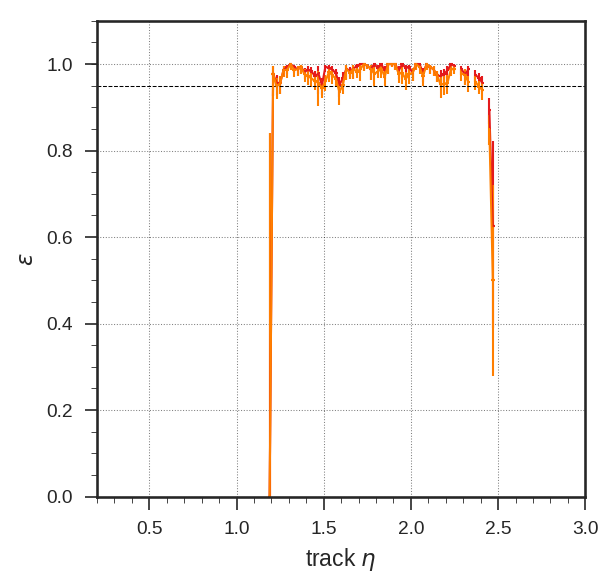

In [22]:
# Efficiency vs eta
plt.figure()

nbinsx = 90
xlow = 0.7
xup = 2.5

eff_data_theta = eff_data[:, 5]  # index 5 is theta_median
eff_data_eta = np.apply_along_axis(theta_to_eta_f, 0, eff_data_theta)

pt_thresh = 20
gen_pt_thresh = 30
gen_passed = eff_data[:, 1] > gen_pt_thresh  # index 1 is pt_true
denom_hist, edges = np.histogram(eff_data_eta[gen_passed], bins=nbinsx, range=(xlow,xup))  

# Efficiency for (L1 pT > 20) only
color = my_palette[1]
passed = gen_passed & (eff_data[:, 3] > pt_thresh)  # index 3 is pt, index 4 is passed
num_hist, edges = np.histogram(eff_data_eta[passed], bins=nbinsx, range=(xlow,xup))
eff_hist = np.true_divide(num_hist, denom_hist)

xdata = (edges[1:] + edges[:-1])/2
xerr = (edges[1:] - edges[:-1])/2
yerr = find_efficiency_errors(denom_hist, num_hist)
ydata = eff_hist
plt.errorbar(xdata, ydata, xerr=xerr, yerr=yerr, color=color, marker=',', capsize=0, lw=1)

# Efficiency for (L1 pT > 20 only && passed)
color = my_palette[3]
passed = gen_passed & (eff_data[:, 3] > pt_thresh) & (eff_data[:, 4] == 1)  # index 3 is pt, index 4 is passed
num_hist, edges = np.histogram(eff_data_eta[passed], bins=nbinsx, range=(xlow,xup))
eff_hist = np.true_divide(num_hist, denom_hist)

yerr = find_efficiency_errors(denom_hist, num_hist)
ydata = eff_hist
plt.errorbar(xdata, ydata, xerr=xerr, yerr=yerr, color=color, marker=',', capsize=0, lw=1)
  
plt.plot([xlow-0.5,xup+0.5], [0.95,0.95], ls='dashed', lw=0.5, color='black')
plt.xlim(xlow-0.5,xup+0.5)
plt.ylim(0,1.1)
plt.xlabel(r'track $\eta$')
plt.ylabel(r'$\epsilon$')
plt.show()

/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-ipykernel/4.9.0-ikaegh/lib/python2.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


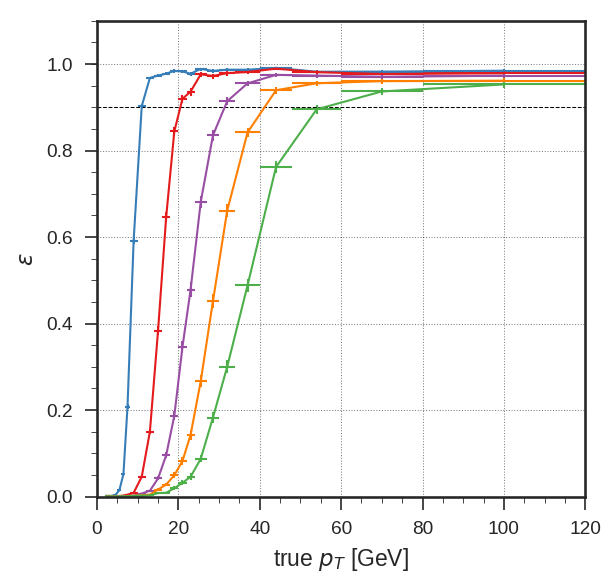

In [23]:
# Efficiency vs pT
plt.figure()

eff_pt_bins = (0., 0.5, 1., 1.5, 2., 3., 4., 5., 6., 7., 8., 10., 12., 14., 16., 18., 20., 22., 24., 27., 30., 34., 40., 48., 60., 80., 120.)

pt_list = (10., 20., 30., 40., 50.)

if omtf_input:
  gen_passed = (0.8 <= eff_data_eta) & (eff_data_eta <= 1.24)
else:
  gen_passed = (1.24 <= eff_data_eta) & (eff_data_eta <= 2.4)

denom_hist, edges = np.histogram(eff_data[:, 1][gen_passed], bins=eff_pt_bins)  # index 1 is pt_true

for pt, color in zip(pt_list, my_palette):
  passed = gen_passed & (eff_data[:, 3] > pt) & (eff_data[:, 4] == 1)  # index 3 is pt, index 4 is passed
  num_hist, edges = np.histogram(eff_data[:, 1][passed], bins=eff_pt_bins)  # index 1 is pt_true
  eff_hist = np.true_divide(num_hist, denom_hist)
  
  xdata = (edges[1:] + edges[:-1])/2
  xerr = (edges[1:] - edges[:-1])/2
  yerr = find_efficiency_errors(denom_hist, num_hist)
  ydata = eff_hist
  #print pt, ydata
  
  plt.errorbar(xdata, ydata, xerr=xerr, yerr=yerr, color=color, marker=',', capsize=0, lw=1)

plt.plot([0,120], [0.9,0.9], ls='dashed', lw=0.5, color='black')
plt.xlim(0,120)
plt.ylim(0,1.1)
plt.xlabel(r'true $p_{T}$ [GeV]')
plt.ylabel(r'$\epsilon$')
plt.show()

In [24]:
# Find out pT scale factor

xmin = 0.
xmax = 60.
nbinsx = 120
xedges = np.linspace(xmin, xmax, num=nbinsx+1)  # edges used to digitize pt_true

nbinsy = 5  # j = zone0-1, zone2-4, zone5, zone6, all zones

# Each bin contains the threshold for ~90% probability for (zone_special, pt_true)
xxx = np.zeros((nbinsy,nbinsx), dtype=np.float32)

for j in xrange(nbinsy):
  if j == 0:
    sel_j = (0 <= eff_data[:,0]) & (eff_data[:,0] <= 1)
  elif j == 1:
    sel_j = (2 <= eff_data[:,0]) & (eff_data[:,0] <= 4)
  elif j == 2:
    sel_j = (eff_data[:,0] == 5)
  elif j == 3:
    sel_j = (eff_data[:,0] == 6)
  elif j == 4:
    sel_j = (eff_data[:,0] >= 0)

  xx = eff_data[:,1][sel_j]  # pt_true
  yy = eff_data[:,2][sel_j]  # xml_pt
  zz = eff_data[:,4][sel_j]  # discr_passed

  ind = np.digitize(xx, xedges[1:])  # split into mutually-exclusive pt_true bins 

  for i in xrange(nbinsx):
    # >>> xedges[:5]
    # array([0. , 0.5, 1. , 1.5, 2. ])
    if xedges[i] <= 2:  # ignore below 2 GeV
      xxx[j,i] = xedges[i]
      continue

    if 0 <= xedges[i] <= 24:
      step = 4  # 2GeV step size
    elif xedges[i] <= 32:
      step = 8  # 4GeV step size
    elif xedges[i] <= 40:
      step = 12 # 6GeV step size
    else:
      step = 16 # 8GeV step size

    xx_i = xx[(i <= ind) & (ind <= i+step)]
    yy_i = yy[(i <= ind) & (ind <= i+step)]
    zz_i = zz[(i <= ind) & (ind <= i+step)]
    coverage = 90.
    coverage += 1.0 # inefficiency due to fiducial cuts
    #coverage += 1.5 # inefficiency due to fiducial cuts

    yz_i = np.where(zz_i==0, 0, yy_i)  # muons who passed
    if len(yz_i) < 100:  # not enough stats
      continue

    pct = np.percentile(yz_i, 100-coverage, overwrite_input=True)
    xxx[j,i] = pct

    # Debug
    if j == 4 and 14 <= xedges[i] <= 30:
      print xedges[i], 100. * (zz_i==0).sum() / (zz_i>=0).sum()
    #print np.mean(xx_i), len(xx_i), pct
    #if xedges[i] == 20:
    #  print i, coverage, np.percentile(yy_i, [1,2,3,4,5,6,7,8,9,10,11,12], overwrite_input=True)
    #  print i, coverage, np.percentile(yy_i[zz_i==1], [1,2,3,4,5,6,7,8,9,10,11,12], overwrite_input=True)

14.0 1.94539249147
14.5 1.8018018018
15.0 1.71385991058
15.5 1.63411717816
16.0 1.7589017589
16.5 1.6393442623
17.0 1.43953934741
17.5 1.33196721311
18.0 1.59914712154
18.5 1.16472545757
19.0 1.18835412953
19.5 1.32995566814
20.0 1.38522427441
20.5 1.34656272147
21.0 1.65041260315
21.5 1.54918667699
22.0 1.29345189976
22.5 1.25838926174
23.0 1.04895104895
23.5 1.01102941176
24.0 1.07317073171
24.5 1.28956623681
25.0 1.30597014925
25.5 1.26742712294
26.0 1.23376623377
26.5 1.19126406353
27.0 1.3167013167
27.5 1.23546511628
28.0 1.05263157895
28.5 0.853374709077
29.0 0.81103000811
29.5 0.906095551895
30.0 0.856164383562


[ 0.0000,  0.5000,  1.0000,  1.5000,  2.0000,  2.5000,  3.0000,  3.5000,
  4.0000,  4.5000,  5.0000,  5.5000,  6.0000,  6.5000,  7.0000,  7.5000,
  8.0000,  8.5000,  9.0000,  9.5000, 10.0000, 10.5000, 11.0000, 11.5000,
 12.0000, 12.5000, 13.0000, 13.5000, 14.0000, 14.5000, 15.0000, 15.5000,
 16.0000, 16.5000, 17.0000, 17.5000, 18.0000, 18.5000, 19.0000, 19.5000,
 20.0000, 20.5000, 21.0000, 21.5000, 22.0000, 22.5000, 23.0000, 23.5000,
 24.0000, 24.5000, 25.0000, 25.5000, 26.0000, 26.5000, 27.0000, 27.5000,
 28.0000, 28.5000, 29.0000, 29.5000, 30.0000, 30.5000, 31.0000, 31.5000,
 32.0000, 32.5000, 33.0000, 33.5000, 34.0000, 34.5000, 35.0000, 35.5000,
 36.0000, 36.5000, 37.0000, 37.5000, 38.0000, 38.5000, 39.0000, 39.5000,
 40.0000, 40.5000, 41.0000, 41.5000, 42.0000, 42.5000, 43.0000, 43.5000,
 44.0000, 44.5000, 45.0000, 45.5000, 46.0000, 46.5000, 47.0000, 47.5000,
 48.0000, 48.5000, 49.0000, 49.5000, 50.0000, 50.5000, 51.0000, 51.5000,
 52.0000, 52.5000, 53.0000, 53.5000, 54.0000, 54.50

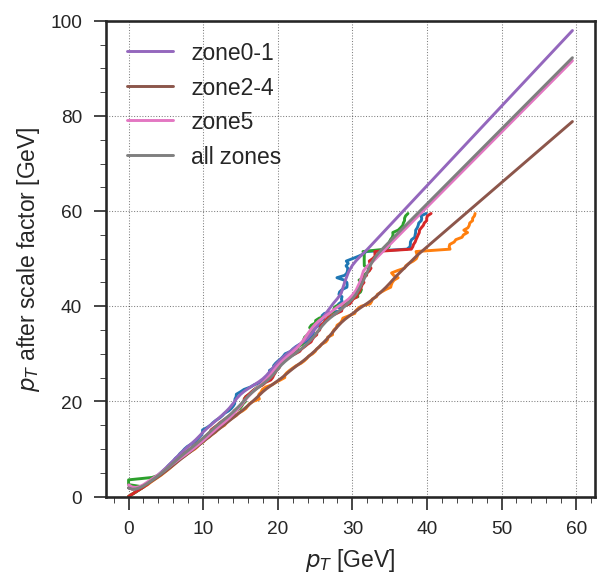

In [25]:
plt.figure()

# Before smoothing
xdata = xedges[:-1]
if omtf_input:
  #plt.plot(xxx[0], xdata)
  #plt.plot(xxx[1], xdata)
  #plt.plot(xxx[2], xdata)
  plt.plot(xxx[3], xdata)
  plt.plot(xxx[4], xdata)
else:
  plt.plot(xxx[0], xdata)
  plt.plot(xxx[1], xdata)
  plt.plot(xxx[2], xdata)
  #plt.plot(xxx[3], xdata)
  plt.plot(xxx[4], xdata)
plt.xlabel(r'$p_{T}$ [GeV]')
plt.ylabel(r'$p_{T}$ after scale factor [GeV]')

from scipy.interpolate import Rbf
rbf0 = Rbf(xxx[0,:-16], xdata[:-16], smooth = 10.0, function='multiquadric')
rbf1 = Rbf(xxx[1,:-16], xdata[:-16], smooth = 10.0, function='multiquadric')
rbf2 = Rbf(xxx[2,:-16], xdata[:-16], smooth = 10.0, function='multiquadric')
rbf3 = Rbf(xxx[3,:-16], xdata[:-16], smooth = 10.0, function='multiquadric')
rbf4 = Rbf(xxx[4,:-16], xdata[:-16], smooth = 10.0, function='multiquadric')

# After smoothing
ydata0 = rbf0(xdata)
ydata1 = rbf1(xdata)
ydata2 = rbf2(xdata)
ydata3 = rbf3(xdata)
ydata4 = rbf4(xdata)

if omtf_input:
  #line0, = plt.plot(xdata, ydata0)
  #line1, = plt.plot(xdata, ydata1)
  #line2, = plt.plot(xdata, ydata2)
  line3, = plt.plot(xdata, ydata3)
  line4, = plt.plot(xdata, ydata4)
  plt.legend((line3, line4), ('zone6', 'all zones'), loc='upper left')
else:
  line0, = plt.plot(xdata, ydata0)
  line1, = plt.plot(xdata, ydata1)
  line2, = plt.plot(xdata, ydata2)
  #line3, = plt.plot(xdata, ydata3)
  line4, = plt.plot(xdata, ydata4)
  plt.legend((line0, line1, line2, line4), ('zone0-1', 'zone2-4', 'zone5', 'all zones'), loc='upper left')

print np.array2string(xdata, separator=', ', precision=4, floatmode='fixed')
#print np.array2string(ydata0, separator=', ', precision=4, floatmode='fixed')
#print np.array2string(ydata1, separator=', ', precision=4, floatmode='fixed')
#print np.array2string(ydata2, separator=', ', precision=4, floatmode='fixed')
#print np.array2string(ydata3, separator=', ', precision=4, floatmode='fixed')
print np.array2string(ydata4, separator=', ', precision=4, floatmode='fixed')

def monotonically_increasing(a):
  return np.all(a[1:] >= a[:-1], axis=-1)
assert(monotonically_increasing(ydata4[6:]))

plt.ylim(0,100)
plt.show()

In [26]:
# Rates
rates_jobid_offset = 159 - 30
rates_njobs = 63
rates_nevents_per_job = 8000
rates_nevents_last_job = 2400
rates_nevents = 498400
assert(rates_nevents == (rates_njobs-1)*rates_nevents_per_job + rates_nevents_last_job)

# Stores highest track pt per event
rates_array = np.zeros((rates_njobs-1,rates_nevents_per_job), dtype=np.float32)
rates_array_last_job = np.zeros((1,rates_nevents_last_job), dtype=np.float32)

for ievt, (x, x_mask, x_road, y_pred, y_discr, aux) in enumerate(zip(pu_x_test, pu_x_mask_test, pu_x_road_test, pu_y_test_pred, pu_y_test_pred_discr, pu_aux_test)):
  ndof = get_ndof_from_x_mask(x_mask)
  mode = get_mode_from_x_mask(x_mask)
  strg, zone, phi_median, theta_median = x_road
  
  passed = mytrigger.pass_trigger(ndof, mode, strg, zone, theta_median, y_pred, y_discr)
  #xml_pt = np.abs(1.0/y_pred)
  pt = mytrigger.get_trigger_pt(y_pred)
  #pt_true = np.abs(1.0/y_true)
  
  (jobid, ievt, highest_part_pt, highest_track_pt) = aux
  jobid = int(jobid) - rates_jobid_offset
  ievt = int(ievt)
  
  trk_eta = theta_to_eta_f(theta_median)
  if omtf_input:
    trk_eta_ok = (0.8 <= trk_eta <= 1.24)
  else:
    trk_eta_ok = (1.24 <= trk_eta <= 2.4)
  
  if jobid < (rates_njobs-1):
    if passed and trk_eta_ok:
      rates_array[jobid,ievt] = max(rates_array[jobid,ievt], pt)
  else:  # last job
    if passed and trk_eta_ok:
      rates_array_last_job[0,ievt] = max(rates_array_last_job[0,ievt], pt)
  
  # Debug
  test_jobs = (31,50,56,60,)
  if jobid in test_jobs and passed and pt > 20.:
    print "{0:4.0f} {1:4.0f} {2:7.4f} {3:7.4f}".format(jobid, ievt, highest_part_pt, highest_track_pt), 
    print "{0} {1} {2}".format(ndof, pt, y_discr)
    if pt > 100.:  # why?
      with np_printoptions(precision=3, suppress=True):
        if omtf_input:
          nlayers1 = 9
        else:
          nlayers1 = 12
        for lay in xrange(nlayers1):
          tmp = np.arange(2) * nlayers1 + lay
          print "....", lay, x[tmp]

  31 2826 19.5646 27.5000 7 [23.34713237] [0.99555826]
  31 2937 11.6057 18.0000 7 [25.39615515] [0.96072537]
  50 4726 11.9545     nan 6 [24.5585582] [0.97311956]
  50 6191 19.5523 14.5000 6 [32.08786033] [0.9631572]
  56 5213 12.2996 21.5000 8 [24.2398215] [0.9967175]
  60 2642 14.2474 26.5000 8 [22.953475] [0.9990827]
  60 2642 14.2474 26.5000 8 [22.953475] [0.9990827]


[INFO    ] nevents: 258400/498400


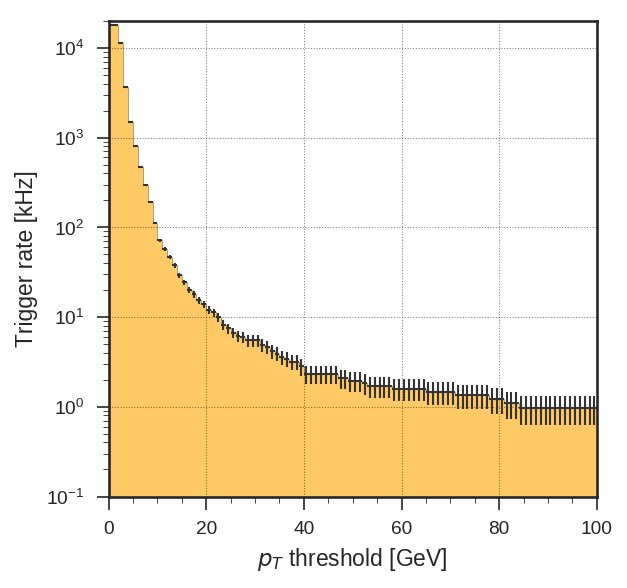

[INFO    ] Rates at 18/19/20/21/22/25 GeV: 15.5205246583, 13.9318095818, 11.9764678851, 11.2432147637, 9.89891735464, 6.72148708254


[1.7754e+04, 1.7754e+04, 1.1454e+04, 3.6424e+03, 1.4885e+03, 8.1171e+02,
 4.7490e+02, 2.9538e+02, 1.8918e+02, 1.1158e+02, 7.1614e+01, 5.7805e+01,
 4.6195e+01, 3.7640e+01, 2.9330e+01, 2.4320e+01, 2.0164e+01, 1.7965e+01,
 1.5521e+01, 1.3932e+01, 1.1976e+01, 1.1243e+01, 9.8989e+00, 8.1880e+00,
 7.4547e+00, 6.7215e+00, 6.1104e+00, 5.9882e+00, 5.4994e+00, 5.4994e+00,
 5.4994e+00, 4.8884e+00, 4.6439e+00, 4.1551e+00, 3.9107e+00, 3.5441e+00,
 3.4218e+00, 3.1774e+00, 3.1774e+00, 2.8108e+00, 2.3220e+00, 2.3220e+00,
 2.3220e+00, 2.3220e+00, 2.3220e+00, 2.3220e+00, 2.3220e+00, 2.0776e+00,
 2.0776e+00, 1.9553e+00, 1.9553e+00, 1.9553e+00, 1.8331e+00, 1.7109e+00,
 1.7109e+00, 1.7109e+00, 1.7109e+00, 1.7109e+00, 1.5887e+00, 1.5887e+00,
 1.5887e+00, 1.5887e+00, 1.5887e+00, 1.5887e+00, 1.5887e+00, 1.4665e+00,
 1.4665e+00, 1.4665e+00, 1.4665e+00, 1.4665e+00, 1.4665e+00, 1.3443e+00,
 1.3443e+00, 1.3443e+00, 1.3443e+00, 1.3443e+00, 1.3443e+00, 1.3443e+00,
 1.2221e+00, 1.2221e+00, 1.2221e+00, 1.0999e+00, 1.

In [27]:
# Rates
rates = np.concatenate((rates_array.reshape(-1), rates_array_last_job.reshape(-1)))
assert(len(rates) == rates_nevents)

# If the rates for a particular jobid is zero, assume the job has failed
rates_nevents_1 = 0
for jobid in xrange(rates_array.shape[0]):
  if rates_array[jobid].sum() > 0.:
    rates_nevents_1 += rates_nevents_per_job
if rates_array_last_job[0].sum() > 0.:
  rates_nevents_1 += rates_nevents_last_job
logger.info("nevents: {0}/{1}".format(rates_nevents_1, rates_nevents))  # should be half the statistics

expected_rates_nevents_1 = 258400
if rates_nevents_1 != expected_rates_nevents_1:
  logger.warning("rates_nevents_1 (which is {0}) != {1}, did some job fail?".format(rates_nevents_1, expected_rates_nevents_1))

def conversion_to_kHz(nevents):
  orbitFreq = 11246.
  nCollBunches = 2808
  nZeroBiasEvents = nevents
  convFactorToHz = orbitFreq * nCollBunches / nZeroBiasEvents
  return (convFactorToHz / 1000.)

rates = rates[rates > eps]
rates = np.clip(rates, 0., 100.)
w = conversion_to_kHz(rates_nevents_1)
weights = np.full_like(rates, w)

plt.figure()
hist, edges, _ = plt.hist(rates, bins=100, range=(0.,100.), cumulative=-1, weights=weights, histtype='stepfilled', facecolor='orange', edgecolor='k', alpha=0.6)
xdata = (edges[1:] + edges[:-1])/2
xerr = (edges[1:] - edges[:-1])/2
ydata = hist
sumw2 = (ydata/w)
yerr = w*np.sqrt(sumw2)
plt.errorbar(xdata, ydata, xerr=xerr, yerr=yerr, color='#333333', ecolor='#333333', fmt='none', capsize=0, lw=1)
plt.xlabel(r'$p_{T}$ threshold [GeV]')
plt.ylabel(r'Trigger rate [kHz]')
plt.xlim(0,100)
plt.ylim(1e-1,2e4)
plt.yscale('log')
plt.show()

logger.info("Rates at 18/19/20/21/22/25 GeV: {0}, {1}, {2}, {3}, {4}, {5}".format(hist[18], hist[19], hist[20], hist[21], hist[22], hist[25]))
print np.array2string(hist, separator=', ', precision=4, floatmode='fixed')

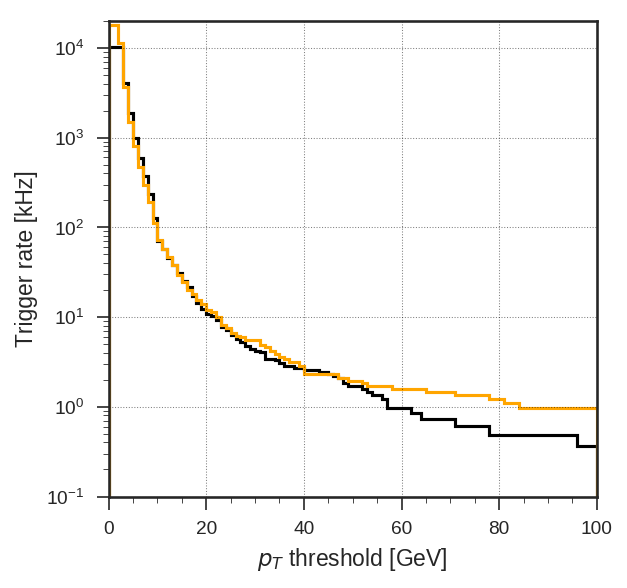

In [28]:
# Old rates
old_hist = [1.0308e+04, 1.0308e+04, 1.0308e+04, 4.0897e+03, 1.8846e+03, 9.9760e+02,
 5.9589e+02, 3.7664e+02, 2.3440e+02, 1.2795e+02, 7.0148e+01, 5.7560e+01,
 4.5217e+01, 3.8007e+01, 3.0797e+01, 2.5542e+01, 2.1509e+01, 1.7354e+01,
 1.4421e+01, 1.2343e+01, 1.0877e+01, 1.0143e+01, 9.2878e+00, 7.8213e+00,
 7.0881e+00, 6.2326e+00, 5.6216e+00, 5.2550e+00, 4.7661e+00, 4.3995e+00,
 4.1551e+00, 4.0329e+00, 3.4218e+00, 3.4218e+00, 3.2996e+00, 3.0552e+00,
 2.8108e+00, 2.8108e+00, 2.6886e+00, 2.6886e+00, 2.5664e+00, 2.5664e+00,
 2.5664e+00, 2.4442e+00, 2.4442e+00, 2.3220e+00, 2.1998e+00, 2.0775e+00,
 1.8331e+00, 1.7109e+00, 1.7109e+00, 1.7109e+00, 1.5887e+00, 1.4665e+00,
 1.3443e+00, 1.3443e+00, 1.2221e+00, 9.7767e-01, 9.7767e-01, 9.7767e-01,
 9.7767e-01, 9.7767e-01, 8.5546e-01, 8.5546e-01, 7.3325e-01, 7.3325e-01,
 7.3325e-01, 7.3325e-01, 7.3325e-01, 7.3325e-01, 7.3325e-01, 6.1104e-01,
 6.1104e-01, 6.1104e-01, 6.1104e-01, 6.1104e-01, 6.1104e-01, 6.1104e-01,
 4.8883e-01, 4.8883e-01, 4.8883e-01, 4.8883e-01, 4.8883e-01, 4.8883e-01,
 4.8883e-01, 4.8883e-01, 4.8883e-01, 4.8883e-01, 4.8883e-01, 4.8883e-01,
 4.8883e-01, 4.8883e-01, 4.8883e-01, 4.8883e-01, 4.8883e-01, 4.8883e-01,
 3.6663e-01, 3.6663e-01, 3.6663e-01, 3.6663e-01]
old_hist = np.array(old_hist, dtype=np.float32)

plt.figure()
centers = (edges[1:] + edges[:-1])/2
plt.hist(centers, weights=old_hist, bins=edges, histtype='step', color='k', lw=1.5)
plt.hist(centers, weights=hist, bins=edges, histtype='step', color='orange', lw=1.5)
plt.xlabel(r'$p_{T}$ threshold [GeV]')
plt.ylabel(r'Trigger rate [kHz]')
plt.xlim(0,100)
plt.ylim(1e-1,2e4)
plt.yscale('log')
plt.show()

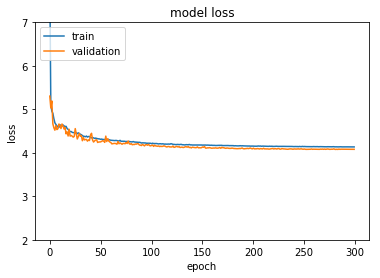

In [29]:
# Training history
# 2019-06-11

"""
[INFO    ] Done training. Time elapsed: 2:31:32.855172 sec
[INFO    ] Epoch 300/300 - loss: 4.13564316837 - regr_loss: 3.66174457964 - discr_loss: 0.015796619711 - val_loss: 4.08047062848 - val_regr_loss: 3.60406795491 - val_discr_loss: 0.015880088905
"""

from IPython.display import Image
Image(format="png", data="iVBORw0KGgoAAAANSUhEUgAAAXwAAAEWCAYAAABliCz2AAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDIuMi4zLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvIxREBQAAIABJREFUeJzt3XmcHVWd9/HP7669L+l0ks5GwpqQEJLQsoddRBCVnRlghHFg9HFEHXUGnXlGZx6dh3F8kMEdFccFQSYYQUEcUBAY1iQkIRsJSyCdrbuT3re7neePU0mapLcst5d7v+/Xq199b926VadudX9P1alT55pzDhERyX2hkS6AiIgMDwW+iEieUOCLiOQJBb6ISJ5Q4IuI5AkFvohInlDgiwBm9p9m9pUhzrvJzC441OWIDDcFvohInlDgi4jkCQW+jBlBU8rnzexVM2s3s3vMbKKZ/c7MWs3sCTOr7DX/B81sjZk1m9lTZja712sLzGy5mbWZ2S+Bgn3W9QEzWxG89zkzm3eQZb7ZzF43s11m9rCZTQ6mm5l9w8zqg7K/amZzg9cuNrO1Qdm2mNnnDumDEwko8GWsuQK4ADgO+ADwGPBFYELw93wrPjSPBe4DPg1UA48CvzGzmJnFgF8DPwPGAf8VLJfgvQuAe4C/BqqA7wMPm1n8QApqZucB/xe4GqgB3gbuD16+EDgLOBYoD+bZGbz2I+CvnXOlwFzgj4fzA5T8pcCXseabzrkdzrktwDPAC865V5xz3cASYEEw3zXAI865x51zSeDrQCFwOnAqEAXudM4lnXOLgZd7reMW4PvOuRedc2nn3E+AnuB9B+I64B7n3HLnXA/wBeA0M5sBJIFSYBZgzrl1zrltwfuSwPFmVuaca3LOLT9Mn53kOQW+jDU7ej3u6uN5SfB4cnBEDYBzLgNsBqYEr21x7x458O1ej48APhs05zSbWTMwLXjfgdi3DO3BUfwU59wfgW8B3wbqzexuMysLZr0CuBh428z+ZGanHeB6RfqkwJdctTUIbgjazIPQ3gJsA6YE03ab3uvxZuCrzrmKXj9Fzrn7DrEMxUET0RZ8BXCXc+4k4PigaefzwfSXnXMfCpqpfg08cAifg8geCnzJVQ8Al5jZ+WYWBT4bNMs8BzwPpIBbzSxqZpcDJ/d67w+Aj5nZKcHF1WIzu8TMSg+wDPcBN5nZ/KD9/1+BF51zm8zsPcHyo0AH0A1kgmsM15lZedAU1QpkDvNnI3lKgS85yTn3GnA98E2gEbgUuNQ5l3DOJYDLgRuBXUF7/696vXcpcHPQ5NIEvB7Me6BleAL438CDwVnFUcC1wctlQcXSFDT77AT+PXjtBmCTmbUCHwuuBYgcMtMXoIiI5Acd4YuI5ImsBb6ZHRfcuLL7p9XMPp2t9YmIyMCGpUnHzMJBz4RTnHNvD+EtIiJymA1Xk875wBsKexGRkRMZpvVcG3RR24+Z3RLc2UhxcfFJs2bNOuCF1zV10d6TYtakA+01JyIyti1btqzROVc9lHmz3qQTjFuyFZjjnNsx0Ly1tbVu6dKlB7yOv1u8kmc2NvL8F84/lKKKiIw5ZrbMOVc7lHmHo0nn/cDywcL+UITMyKh7qYjIgIYj8P+sv+acw8XMyCjvRUQGlNXAD8YOeW/vuxizIWSgG8hERAaW1Yu2zrmOYLCog5ZMJqmrq6O7u7vfeT4wPcP5k6pYt27doawqLxQUFDB16lSi0ehIF0VEhtlw9dI5aHV1dZSWljJjxgzePbjhXluau2juTDB7cvmwl28scc6xc+dO6urqmDlz5kgXR0SG2agfWqG7u5uqqqp+wx6g/1ekNzOjqqpqwLMlEcldoz7wCYJqUGrCH5IhfZYikpPGROAPxpT3IiKDyonAz2abTnNzM9/5zncO+H0XX3wxzc3NWSmTiMjByI3Az+IRfn+Bn0qlBnzfo48+SkVFRZZKJSJy4EZ9L52hyGar9G233cYbb7zB/PnziUajFBQUUFlZyfr169mwYQMf/vCH2bx5M93d3XzqU5/illtuAWDGjBksXbqU9vZ23v/+93PmmWfy3HPPMWXKFB566CEKCwuzWGoRkf2NqcD/59+sYe3W1v2mJ9IZkqkMxfED35zjJ5fxpUvn9Pv67bffzurVq1mxYgVPPfUUl1xyCatXr97TrfGee+5h3LhxdHV18Z73vIcrrriCqqp333qwceNG7rvvPn7wgx9w9dVX8+CDD3L99dcfcFlFRA7FmAr80eDkk09+Vx/2u+66iyVLlgCwefNmNm7cuF/gz5w5k/nz5wNw0kknsWnTpmEutYjIGAv8/o7Ed7R2s6O1mxOmlGe922FxcfGex0899RRPPPEEzz//PEVFRZxzzjl99nGPx+N7HofDYbq6urJaRhGRvuTMRdtsKS0tpa2trc/XWlpaqKyspKioiPXr1/PCCy8Me/lERIZqTB3h92f3Mb3LwgXcqqoqzjjjDObOnUthYSETJ07c89pFF13E9773PWbPns1xxx3HqaeeepjXLiJy+AzLd9oOVV9fgLJu3Tpmz5494PvqW7vZ3trN3CnlhHQn6aCG8pmKyNgw2r4AJft6H+KLiEifciLwlfciIoPLicBX5IuIDC5HAt9T3IuI9C8nAt90gC8iMqicCHwRERlcTgT+aDrALykpAWDr1q1ceeWVfc5zzjnnsG/3033deeeddHZ27nmu4ZZF5FDlROCPRpMnT2bx4sUH/f59A1/DLYvIoVLgD+K2227j29/+9p7nX/7yl/nKV77C+eefz8KFCznhhBN46KGH9nvfpk2bmDt3LgBdXV1ce+21zJ49m8suu+xdY+l8/OMfp7a2ljlz5vClL30JggHZtm7dyrnnnsu5554LwXDLjY2NANxxxx3MnTuXuXPncuedd+5Z3+zZs7n55puZM2cOF154ocbsEZF3GVtDK/zuNtj+6n6TyzIZ4skM4Vi41xXcIZp0Arz/9n5fvuaaa/j0pz/NJz7xCQAeeOABfv/733PrrbdSVlZGY2Mjp556Kh/84Af7Hbjtu9/9LkVFRaxbt45Vq1axcOHCPa999atfZdy4caTTac4//3xWrVrFrbfeyh133MGTTz7J+PHj37WsZcuW8eMf/5gXX3wR5xynnHIKZ599NpWVlRqGWUQGpCP8QSxYsID6+nq2bt3KypUrqaysZNKkSXzxi19k3rx5XHDBBWzZsoUdO3b0u4ynn356T/DOmzePefPm7XntgQceYOHChSxYsIA1a9awdu3aAcvz7LPPctlll1FcXExJSQmXX345zzzzDGgYZhEZxNg6wu/nSLytI0FdUyezJpUSi4QP+2qvuuoqFi9ezPbt27nmmmu49957aWhoYNmyZUSjUWbMmNHnsMiDeeutt/j617/Oyy+/TGVlJTfeeONBLWc3DcMsIgPJiSP8bPfSueaaa7j//vtZvHgxV111FS0tLUyYMIFoNMqTTz7J22+/PeD7zzrrLH7xi18AsHr1alatWgVAa2srxcXFlJeXs2PHDn73u9/teU9/wzIvWrSIX//613R2dtLR0cGSJUtYtGjRYd9mEck9Y+sIvz9ZTvw5c+bQ1tbGlClTqKmp4brrruPSSy/lhBNOoLa2llmzZg34/o9//OPcdNNNzJ49m9mzZ3PSSScBcOKJJ7JgwQJmzZrFtGnTOOOMM/a855ZbbuGiiy5i8uTJPPnkk3umL1y4kBtvvJGTTz4ZgL/6q79iwYIFar4RkUHlxPDIzZ0J3tnVybETSymIHv4mnVyj4ZFFckf+DY8sIiKDUuCLiOSJMRH4gzU77WnCHz2tU6PWaGrCE5HhNeoDv6CggJ07dw4cVBouc0icc+zcuZOCgoKRLoqIjIBR30tn6tSp1NXV0dDQ0O88Xck0O9sTuKY4scior8NGVEFBAVOnTh3pYojICBj1gR+NRpk5c+aA8/xh3Q5ufngpD//NGcyeqgHGRET6khOHw6GgSSejFh0RkX5lNfDNrMLMFpvZejNbZ2anZWc9/ndGFyRFRPqV7Sad/wAec85daWYxoCgbK9l9hK8eKCIi/cta4JtZOXAWcCM+jBNAIhvr2h346Uw2li4ikhuy2aQzE2gAfmxmr5jZD82seN+ZzOwWM1tqZksH6okzkFCwFWrSERHpXzYDPwIsBL7rnFsAdAC37TuTc+5u51ytc662urr6oFa096KtAl9EpD/ZDPw6oM4592LwfHFQARx2e9vws7F0EZHckLXAd85tBzab2XHBpPOBgb/O6SCF1EtHRGRQ2e6l80ng3qCHzpvATdlYiakfvojIoLIa+M65FcCQxmk+FDrCFxEZXG7daatDfBGRfuVE4IdDatIRERlMTgS+hlYQERlcTgS+hlYQERlcTgW+mnRERPqXI4Hvf6tJR0SkfzkR+OqHLyIyuJwI/D1H+Ep8EZF+5Ujga/A0EZHB5ETgqx++iMjgciLw1Q9fRGRwORH46ocvIjK4nAp8NemIiPQvRwLf/1aTjohI/3Ii8E2jZYqIDConAn/vEf5Il0REZPTKicDf2y1TiS8i0p+cCHwNrSAiMricCPzdTTrqliki0r8cCXw16YiIDCbHAn+kSyIiMnrlRODvHlohrcQXEelXTgS+hlYQERlcZKQLcMicI/LIrVwaKifjjh3p0oiIjFpj/wjfDFv3G2pDr+mirYjIAMZ+4ANWXE2VteqirYjIAHIi8CmuZry1qg1fRGQAORL44xlvrWrSEREZQI4EfjVVtHLRxn+BtQ+NdGlEREalnAn8SmvjhMZH4IG/GOnSiIiMSjkS+ONHugQiIqNejgR+9d7HJRNHsiQiIqOWAl9EJE/kXuCHYyNZEhGRUSurQyuY2SagDUgDKedcbVZW1LsNP9GRlVWIiIx1wzGWzrnOucasrqGwkrSFCbs0mURHjpy2iIgcXrmRjWZsmPs51mSOINPTPtKlEREZlbId+A54wsyWmdktfc1gZreY2VIzW9rQ0HDwazr9b3g2MxdLdh5CcUVEcle2A/9M59x84P3AJ8zsrH1ncM7d7Zyrdc7VVldX972UIZhRVUwXccLpbsikD7XcIiI5J6uB75zbEvyuB5YAJ2drXYWxMCUl5QBkenThVkRkX1kLfDMrNrPS3Y+BC4HV2VofQO2x0wB4as2mbK5GRGRMyuYR/kTgWTNbCbwEPOKceyyL6+OEGTUAPL367WyuRkRkTMpat0zn3JvAidlafl/CBcUA1O3Ibi9QEZGxKDe6Ze4W84Hf1NJMR09qpEsjIjKq5FbgR33gF9HN+u2tI10aEZFRJbcCP7Y78HtYu1WBLyLSW04GfnU8zatbWka6NCIio0puBX60CIDjxhlLNzWNdGlEREaV3Ar84Aj/6MoQbzZ2UN/WPdIlEhEZNXIy8GeUGQAvv6WjfBGR3XIr8ENhCMeZEE9SFAvz5Gv1I10iEZFRI7cCH3+UH052cHXtNB5cXseKzc1++gvfhaX3+MfL/hNe/P6IFlNEZLjlXuBXHwdbX+GzFx7L3JIO/umXz9LRnYTHboPffoavfO8/ST3176Qf+wLfevAJkunMSJdYRGRYDCnwzexTZlZm3o/MbLmZXZj94h2EI8+BrSsode08UPCv3NzyTb52/94hfP5s6+1E2uoIuzTVr3yTv/jRS/xm5VZerVM3ThHJbUM9wv9L51xrMOJlJXADcHuWy3ZwZp7tv3dl9YMUtr3FBQXrad7wHAC/S5/MUaFtANTFj+Ly+Is0bdnAv93/e6774Qu0azgGEclhQw18C35fDPzMObem17TRZWotxErg2f8AoDDZzOcnvEyni/PctJv9POEYU6+4nWi6i8fsk/yp8O9o7U7xixcHGGUzkwZ9faKIjGFDDfxlZvbfQeD/PhjnfnQ2foejMPtSaHlnT500tfllYtMW8MUbr4AJc2DKSXDUeVDsv2ErnElw1lGV3PnERl546Xl486n9l/vi9+Gu+ZBODvcWiYgcFkMN/I8CtwHvcc51AlHgpiyX7eDVftT/rpkHBRUARN77JQpjYfjzX8IVP4JwBM7/ElQdA8A3LiznqOoSdv32y6QeuHH/ZW5bAR0N0PDasG6KiMjhMtTAPw14zTnXbGbXA/8IjN6rnFNrYdYH4ISr4JYn4W/XwRGn+9cqpkH5FP944Q1w2fcAqOraxI9veg9Hh7YR6W7i+dUbqG/tdaduU9Dcs23FsG+OiMjhMNQvQPkucKKZnQh8Fvgh8FPg7CyX7+CYwbX3Dm3e8f4InyUfY/zsDzIuvAPS8O/3PsKa8Cz+7qJZnH1sNTN3vUUYcFtXYAuuz2rxRUSyYahH+CnnnAM+BHzLOfdtoDTLZRseBf6Lz+lphRU/J5T2R/X/Z1EBJ88cx//57VouueNxwh07AHh16dN89ZG1fOjOJ3j1pT8OfT3pJKx+UNcARGTEDDXw28zsC0F3zEfMLBS04+esOfFGfvqXJ7Pkf53OXRdVAdDoyjnGbeJHz7zBhU33M+eRy/neg7+npWsIIf74P8Hiv4R1v8l+4UVE+jDUwL8G6An6428HpgL/nuWyDZ+P/BYu/Q+wsH8eL4ety7Fdb7JgeiXvm9IDQMXCyyikhx9dUs7HJq4lZA73ys+4/N8W88iqbf0vv70eXviOf9ysL1gXkZExpMAPQv5eoNzMPgB0O+d+mv3iDZOZi+CkG2HyfP81iTXz4I0/wrdq4Y9fhV1vARCZ+2EAzs28QLh+DYSifDzyG/7Ax/jyL/7AZ365ggeX1fH8Gzu57cFVbG3uYvk7TTSsenzvuhpfP/DyvfBd2P7qYdtcEclPQ7poa2ZXB0f0TwWd279pZp93zi3OfhGH0emfhMaNUDYFLAQlE+Dpr0GkwPfZn3EmRArh+W/5+S/5OvzmUwD8/bwu/mnlJpa8smXP4h5cXkcy7fj7yO+4ORqByQvo2bqOSCpNPBIeWpm6W/04QAuuhw99OyubLSL5Yai9dP4h6INfj68AqoEngNwK/DmX7X284DpwDsYfB2/8AS65w9/UNWku1L0MM4KzghOugn+dwpVtP+OKog2s+eBveaFlHEdWF/PDZ97iw/OnsOCZu9jQPIWV75RwYWgp77v9j1y+cCpt3SmOrynlnOMmMLWyELM+bl5u3Oh/b3/V3+1rId8LSUTkAA018EO7wz6wMydH2tyXGZz9ef+zW818H/infcI/jxXD+GNh20oMmPv2z5g790rAcd5fLfLL+NMmdh5zOuO6J1O15UlOqwlx99NvUhwLc99LaWANJfEIUysLOfPo8bR0JTl+chlHVZcw4c2lzAJc/ToS31hAx3EfpvKSf+67chARGcBQA/8xM/s9cF/w/Brg0SyWa/RaeANE4nDM+/ZOqzkRGl+DUNSPtb/sP/30Mz4Nrz0K7dupOv0k3ld1FNz3Lb753hL+7UPHUPjHfyT9zks8cdy/8IKbw+v17dzzP29RHIvwX8vqALgt8gyzImDpBPG2t+l6+Yecu+pUFh49mVmTSqkqjlNVEmNccYydHQmioRAnTC2nvDDK6i0tpDOOE6dVjNCHJSKjyZAC3zn3eTO7AjgjmHS3c25Jdos2StWc6H96mzwfXn0APvhNPw7P7A/A01+H/7lz7zxTa2HcURCOwzNfp2j7q9DTRsTCXNT+ay76s6sB6OzsoHDZ98k8eyedlbOIdjaQ7iwmnOogY2Eq6OBjFS/wtdcW8avlW+hLNc1MGVfEyqYYkZBxw6kzKIqFiUVCRMMhZk0qJRI2pjc8TVn9y2yY93kWTK8kFgnRnUzT1Jmgprwwm5+iiIwA8/dTjQ61tbVu6dKlI12MA9fdChse8+35u5tatr4Cj34eLv46hGMw8Xg//bEv+C6aRVXwFw/7iuK5b8GxF0HrFmipg85GOPJc2LYSunb56wXbV/lrDPXroe4l3KLP0nHyrezsCdPY3sOujiRlBRGSqQyzHrqY7mSSe+bey5ptrby0aRchM9IZv6+raKHaWvhW9C6ODm3lop7b2cB0xpfE6UqkaetJsXB6BTUVhVQURqkqjlFdGgczFkyrYM7kMjUpiYwSZrbMOVc7pHkHCnwza/ODy+//kj/wd2WHUtB9jdnAPxAdjfDo53yPoCkn+Yuy3zkViifAxDlQNA7mXQ1HXwDbV8P3zoCLbodjLoSSib5C+e1nYNUvfUVw9U9h5xu+f3/JBN+t9Ifn+XUd8z5cYQXp874MoTCZbSvotBIKHvkk8ZY3sWDXbjr6Bn5V9XHaWxrpilUyobSAZ19vpKkzQXNHgnRXM62uEBdctjl6Qgnt3Sni0RDFsQhlhRHmTC6nOB4hZBA2Ix4NMXdyOSvqmpldU0Z1SXxPhTOjqpjyoiiZjMOMIVUezjmcg1BIFY1Ib4ct8IdbXgR+X1rqfJiH+7h5OZWASGz/6ct/Bg//zf7TQxF/A1lBmR/dMxSFaBGEQtDV5OexEFRM92cm00+F1/8A5VOhbZsfSTQUhuZ3fPNU+w6oe5l0UTWNVyzm0e3lPL3mbc4Mr2Z10Sm0JYydbV1s2N5EIuU4L/QKT2VOpIc+ytzL1MpC6tt6yGQcUyoLae9OUV0a59iJpSTTGUoLIiTTjrbuJCXxCM+9sZNEOsM5x1Zz6pFVVBRFqSkvJOMcDW09lBdGKYpFeHtXBwWRMKceVUVRNEwoZCTTGZo7k1QURWnqTFDf2qOzFMkZCvx88fy3oavZnylUTIfGDfDSD2DqSX600EQ7lE+HR/7WPz7/n/wZRkG5Hz20q9lXMr/9jO/26TLQsnnv8sunQ7QA5l4BL//QX3849kJo3gyvPw7TToET/wz++x8h2QmVM2HXG2TmXM6uC77BphceZnbrM6yb+RFKtjzLrpqzaS+dycb6dtZua2VSWQGxSIh3dnZSEo+wtaWLTTs7iIVDtHaniIVDlBf6kD56QgkTSgt4fO12WruH9s1k8UiICWVxGtp66E6+++sbxpfEKYmHmVhWQGiQ4A+FoKzAV8bpjMMB5YVRelIZimNhyouilMYjdCbSTCiNUxSPYEB1aRwzo7MnRUciTSqdIe0cGQfTxxUxviRGJgNp50hn/E9hNExFUZRUxhE2wwyK4xEqi6L7neFkMo5UxhGL5H6HOemfAl8Ozq63YOPjMOkEXxFMOWnvNYnNL/nrDw3rfeVx4p/Duof945r5MPU9sPYhf8aw7mF/FuGCkA3HId3jb2A74gyonAE7X4ejz/evF47zr7+62K937pUw/8+hcyfsetN/Z0FJNThH6plv0GplbDvqKuoamqnYtZJx1TVsZzw9iSRTaiZR39bD2q2tNLb3sLO9h6riGNPHFdLW0UWxayNeMZnl7zTRnUxT39oz6MeSymRo7U4RwlHj6tkRnkRLV5J4JERnIk1zV5JEKkPIIJOFf6eQQWE0TGcyTUVwJuOco6kzSU8qTVlhlEQqQ1lBlNKCCPFoiHgkTCwcIhzylUZVcYxUxpFxjsJohOK4f90BO1q72dWRoKokTkdPipnji2npShI2ozAWpiAapjAapjAWIhIKsb21m4qiKMmUozgepro0TjLtaO5M0N6TorIoRkk8ggua4ujVLhwyIxo2wiEjZIb5wCIUNO0VRENUFsXIOEd3MkMsEiJkUBSLsKW5iwmlcRKpDFubu5hQVkAi5c8GS+IRv8yQEQ6WFwoZmYyjpStJQTRMPBoimXZkMo6qkhjJlKMrmSYSNuKRELFIiFg4tOfML5Hyf7+RYLkEFX5nIkVxLDJqmhcV+JI9Pe3+S2CmLPShvfwncMZnoNgPMIdzsOH3sOmZ4M7kONx7Nbzno5Ds8hezd70FxeOh6a13L7vqGN8k1bDOf3FNT6uvNCIFvpJI9QTvMZh/nb9Q3tnoK5dYiV/Xos/6SqKgHCbMhpX3wxtPQrwE4mXQth0u/Iq/3lEx3XebrTjCz1s+zd9kt/pX8L5/haqj/eH9pmfhpbv9SKevPQqX3gUnfWRvuTt30RMtIxYJ09DeQyKVIZOB+rbuPUfoRdEIhS0bcWVTidY9zzvdhWwrnk04HCYc8kEYDhndyQy7OnqIhEKkncM5x5bmblo6E5QFZzudiTRhM0oLohTFwjR3JYhHwrR2JWnrTpFIZ0ikMvSk0kHIQ1NHgkjYh2zvM46Mg4llcSqKYuzqSFAQDfFWYwfjimM4B93JNN3JDIn03jOkWDj0rue5Jho2zGxP4BNUupHQ3u0ujIYpjof3nJWZGV3JNF2JNEWxMMXxCA5HJlhEJsjZkBmh3fs7OIMLmTGuOMYv//q0gyqvAl9Gl542iO8zmrZzsPlFKJ3kgzwchYoZ/oxi43/Dml9DWQ1MPw3WP+KvR2RS/vnqB32lc/T5/kxg0//419953vd0ipdBogNc2veGmnetv6jdusWH9o7VA5fXwv6Y1GX89Y9kZ7DMdiit8b+nn+6bwVLdvtIpnQxHn+cPZdu2+fe3bIFxM/2wHA3r/Q17JRP9dZHdJsyBY97r35Po8DfxVc7w625Y78s77RQ/LVrolxWKQEc9dLf419c/4s+Qzr7NV6Rt2/01mNat/gt/Nj3rOwfU3uQrxrUPwSl/7edNJfxnU1rjbyJs24YrqsJS3fDqf/mmwdJJpNIZulO+IqkojNKZTBPvbqCncTM7CmYQjRVQHjeKi4tp2tVAqmkLqfIjIFqI9bT5b0QtKCeTgUQ6Qya4CJ9xbs9j56Ar6BYMUBANk0xl6EllaO9JMqOqmJ0dCTLOMa2yiF0dCeLREG3dKTp6UqSDM5iMC5renAMzyoMzoK5kmljYMIzGjh5i4RBFsQjpjF9HTypDT9JXkmnnKAmO4pPpDOmMI5l2FERDFMXC7GjtoSvpK97ORBqAwliIgkiYjkSKrkTaNxUGgb77XCDj/FnP7qa9TFCpl8QjfO3KE/v6axyUAl9yWyrhAzUSf/f07hZo3QbVx/nQa9u2t3lqt0SH7/3UttU3U535t/5MomG9D8iyyf5of9lPfHfaRLs/E1gQ3HDXtAke/Kgvw8Q5ECvy1y62vgJvPe0riNKJfl0lk2DXG75c5dPgyHNgxb2+d9X0U/363vqTf29BhQ/znRt9xQZ+3KZw1JdvIJECn5bpHl9ZufT+88RKIdHW6z2FfnsSHZBJ+rOk0hpfKYYi/vXl6apZAAALPklEQVREm9+ewkr/26X9ZxEt8p9hyzt+WQXlkOz26x93pO+EkE74SvCI0+C13/lKs7TGb2Nxta+ICiv9vA3r/ZljQTlUz/KfeUsdFFb45sDWLb6cVUf5b55L98C0U/31pfYGf49LYaWv/NI9ft901Psz0Jr5viyhsN+f4Zj/TMMxP1RJ42t+e7qa/Tfhte3w29jZ6A8qSib6vyHwTYyZFLz9nN/Ooy/w80WL/FlrOOL3RaLDH7hY2H+uoeD3nuehfZ6HfWW78C8O5r9BgS8yamUy/h++t3TS//OHQj4supp8s1VRlQ+n+rU+iBLt/r6MTNqHY0G5f3zk2b6CW7PEv7/yCB9UpTW+Uqk50c+7Zok/8j/ybFj7sK80o0X+rKJpk1/PtFP8+tu2w3EX+eawdNKv20J+vmQXVB/r5y2t8U14ReN86G5+yYfh5AXwys/9+o44DSYc74O9q8mXqW2bf1w4zs9bUOYDtX69r3Cqj/UVZarHN7+FY74SqJzhy71lud/WonG+CW9fkUL/OTSsDyqrjF/Wvr3Mi8b7CiFe5iuWoiof4vEy/7m0bYdWf9c7YX8vChPn+jOmnl7f8hqO+3W4tF9fJr33ucvsvZ7Vn5KJ8LkNB/UnNaoC38zCwFJgi3PuAwPNq8AXySO7s+dQu8f2tPnw330EH4kH3ZPNV1a9z/AyaR/w6YQP4cLKva/tnjfR4UN7d7m6mnz35ljx3mmphO/RVljpK8PCSj+P2f5nnru31bm9FcB+FYLzlddBOJDAH+pYOofiU8A64LDepCUiY9zhug8iXrr/NaLd9r23JRSGUKG/HtLfvLHid0/vXSnsFon5JiYYWlD7OwxHfMzJrK7dzKYClwRfei4iIiMo29XNncDf+Uv0fTOzW8xsqZktbWhoyHJxRETyV9YCP/gqxHrn3LKB5nPO3e2cq3XO1VZXV2erOCIieS+bR/hnAB80s03A/cB5ZvbzLK5PREQGkLXAd859wTk31Tk3A7gW+KNz7vpsrU9ERAamUZdERPLEcHTLxDn3FPDUcKxLRET6piN8EZE8ocAXEckTCnwRkTyhwBcRyRMKfBGRPKHAFxHJEwp8EZE8ocAXEckTCnwRkTyhwBcRyRMKfBGRPKHAFxHJEwp8EZE8ocAXEckTCnwRkTyhwBcRyRMKfBGRPKHAFxHJEwp8EZE8ocAXEckTCnwRkTyhwBcRyRMKfBGRPKHAFxHJEwp8EZE8ocAXEckTCnwRkTyhwBcRyRMKfBGRPKHAFxHJEwp8EZE8ocAXEckTCnwRkTyhwBcRyRNZC3wzKzCzl8xspZmtM7Pbs7UuEREZXCSLy+4BznPOtZtZFHjWzBY5557J4jpFRKQfWQt855wD2oOnUSAMNGVrfSIiMrCstuGbWdjMVgD1wFPOudV9zHOLmS01s6UNDQ3ZLI6ISF7LauA759LOufnAVGCRmZ3bxzx3O+dqnXO11dXV2SyOiEheG5ZeOs65ZuARoHY41iciIvvLZi+dajOrCB4XAu8FVmRrfSIiMrBs9tKpAX5iZqGgYvm5c+7xLK5PREQGkM1eOquABdlavoiIHBjdaSsikicU+CIieUKBLyKSJxT4IiJ5QoEvIpInFPgiInlCgS8ikicU+CIieUKBLyKSJxT4IiJ5QoEvIpInFPgiInlCgS8ikicU+CIieUKBLyKSJxT4IiJ5QoEvIpInFPgiInlCgS8ikicU+CIieUKBLyKSJxT4IiJ5QoEvIpInFPgiInlCgS8ikicU+CIieUKBLyKSJxT4IiJ5QoEvIpInFPgiInlCgS8ikicU+CIieUKBLyKSJxT4IiJ5QoEvIpInshb4ZjbNzJ40s7VmtsbMPpWtdYmIyOAiWVx2Cvisc265mZUCy8zscefc2iyuU0RE+pG1I3zn3Dbn3PLgcRuwDpiSrfWJiMjAsnmEv4eZzQAWAC/28dotwC3B03Yze+0gVzMeaDy0ko4a2pbRJ1e2A23LqHWw23LEUGc059xBLH/ozKwE+BPwVefcr7K4nqXOudpsLX84aVtGn1zZDrQto9ZwbEtWe+mYWRR4ELg3m2EvIiKDy2YvHQN+BKxzzt2RrfWIiMjQZPMI/wzgBuA8M1sR/FycxfXdncVlDzdty+iTK9uBtmXUyvq2ZL0NX0RERgfdaSsikicU+CIieWLMB76ZXWRmr5nZ62Z220iX50CZ2SYzezW4xrE0mDbOzB43s43B78qRLmdfzOweM6s3s9W9pvVbdjP7QrCfXjOz941YwfvQz7Z82cy29HUNapRvS5/Dmoy1fTPAdoy5/WJmBWb2kpmtNLN1ZnY7I7FPnHNj9gcIA28ARwIxYCVw/EiX6wC3YRMwfp9pXwNuCx7fBvzbSJezn7KfBSwEVg9WduD4YP/EgZnBfguP9DYMsi1fBj7Xx7yjfVtqgIXB41JgQ1DmMbVvBtiOMbdfAANKgsfR4CbURcO9T8b6Ef7JwOvOuTedcwngfuBDI12ow+BDwE+Cxz8BPjzC5emTc+5pYNc+k/sr+4eA+51zPc65t4DXg/03KvSzLf0Z7dvS37AmY2rfHMTwLKNyO/Dld8659uBpNDhYbRrufTLWA38KsLnX87oxOF6PA54ws2XBMBMAE51z24LH24GJI1i+A9Vf2cfqvvqkma0Kmnx2n26PmW3ZZ1iTMbtv+hieZcztFzMLm9kKoB54yjm3erj3yVgP/FxwpnNuPvB+4BNmdlbvF50/vxuTfWfHctkD3w2aC+cD24D/N9IFOhDBsCYPAp92zrX2fm0s7Zs+tmNM7hfnXDr4X58KLDKzc/d5Pev7ZKwH/hZgWq/nU4NpY4Zzbkvwux5YEpy27TCzGvwfe01wRDBW9Ff2MbevnHM7gn/SDPCDXqfUo35b+hnWZMztm762YyzvF3z5m4FHgNrh3idjPfBfBo4xs5lmFgOuBR4e6UINlZkVB98VgJkVAxcCq4Nt+Egw20eAh0a2pAekv7I/DFxrZnEzmwkcA7w0guUc1O5/xMBlwb5htG/LAMOajKl90992jMX9YmbVZlYRPC4E3gusGPZ9MtJXrw/D1e+Lg6v3bwD/MNLlOcCyHxlciV8JrNldfqAK+AOwEXgCGDfSZe2n/PcFp9TJoI3xowOVHfiHYD+9Brx/pMs/hG35GfAqsCr4B6wZI9tyZtA0sCoIlRXB/8mY2jcDbMeY2y/APOCV4H/9VeDv3SD/69nYFg2tICKSJ8Z6k46IiAyRAl9EJE8o8EVE8oQCX0QkTyjwRUTyhAJf5DAws3PM7LcjXQ6RgSjwRUTyhAJf8oqZXR+MS77CzL4fDGjVbmbfCMZc/4OZVQfzzjezF4JBupbsHqTLzI42syeCsc2Xm9lRweJLzGyxma03s3uDO0VFRg0FvuQNM5sNXAOcEQxilQauA4qBpc65OcCfgC8Fb/lpcEfkvODuyN3T7wW+7Zw7ETg9uEOXYDTHTwdjmR8JnDFCmyrSp8hIF0BkGJ0PnAS8HBx8FwaDVWWAXwbz/Bz4lZmVAxXOuT8F038C/Fcw9tEU59wS/NAk3fjKBOAl51xd8HwFMAN4dmQ2VWR/CnzJJwb8xDn3hXdNNPvf+8x3sOON9PR6nNb/l4w2atKRfPIH4Eozm8De7xM9Ivg/uDKY58+BZ51zLUCTmS0Kpt8A/Cn45qU6M/twsIy4mRWN2BaJHAAdgUjecM6tNbN/BP7bzELByJifADqAk4PX6oN2foLhar8XBPqbwE3B9BuA75vZvwTLuGoEN0tkyDRapuQ9M2t3zpWMdDlEsk1NOiIieUJH+CIieUJH+CIieUKBLyKSJxT4IiJ5QoEvIpInFPgiInni/wMR0YyM8Y3mnQAAAABJRU5ErkJggg==")